In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.6 MB/s eta 0:00:00


# get climate data

In [ ]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import pandas as pd
import io

def read_and_aggregate_data(file_path, variable_name):
    # Configure boto3 to access the public bucket without signing requests
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

    try:
        # Download the dataset from S3
        response = s3.get_object(Bucket='wbg-cckp', Key=file_path)
        data_stream = io.BytesIO(response['Body'].read())
        data = xr.open_dataset(data_stream)  # Open the dataset

        # Define the coordinate ranges for the three regions
        regions = [
            {"lat": slice(1, 7), "lon": slice(100, 105)},       # Peninsular Malaysia
            {"lat": slice(4, 7.5), "lon": slice(115.5, 119.3)}, # Sabah
            {"lat": slice(2, 4), "lon": slice(112, 114.6)},     # Sarawak
        ]

        # Aggregate data for all regions combined
        aggregated_values = []
        for coords in regions:
            subset_data = data.sel(lat=coords["lat"], lon=coords["lon"])  # Subset for region
            region_aggregated_data = subset_data[variable_name].mean(dim=['lat', 'lon'])
            aggregated_values.append(region_aggregated_data)

        # Combine the aggregated values for all regions
        combined_data = sum(aggregated_values) / len(regions)
        df = combined_data.to_dataframe().reset_index()
        data.close()  # Close the dataset

        return df

    except Exception as e:
        print(f"Error accessing or processing the file: {e}")
        return None


In [ ]:
def create_dataframe(v):
  base_url = f"data/cmip6-x0.25/{v}/access-cm2-r1i1p1f1-historical/timeseries-{v}-monthly-mean_cmip6-x0.25_access-cm2-r1i1p1f1-historical_timeseries_mean_1950-2014.nc"
  variable = f"timeseries-{v}-monthly-mean"
  data = read_and_aggregate_data(base_url, variable)
  data = data.rename(columns={f'timeseries-{v}-monthly-mean': v})

  return data

In [ ]:
pr = create_dataframe('pr')
tas = create_dataframe('tas')
hurs = create_dataframe('hurs')
tasmin = create_dataframe('tasmin')
tasmax = create_dataframe('tasmax')
prpercnt = create_dataframe('prpercnt') # Precipitation Percent Change
cdd = create_dataframe('cdd') # Max number of consecutive dry days
cwd = create_dataframe('cwd') # Max Number of Consecutive Wet Days
sd = create_dataframe('sd') # Number of Summer Days (Tmax > 25°C)
spei12 = create_dataframe('spei12') # drought index

In [ ]:
cdd['cdd'] = cdd['cdd'].dt.total_seconds() / (60*60*24)
cwd['cwd'] = cwd['cwd'].dt.total_seconds() / (60*60*24)
sd['sd'] = sd['sd'].dt.total_seconds() / (60*60*24)

In [ ]:
import pandas as pd

dfs = [pr, prpercnt, hurs, spei12, tas, tasmin, tasmax, cdd, cwd, sd]
historical_climate = dfs[0]

# Extract Year and Month before merging
historical_climate[['Year', 'Month']] = historical_climate['time'].dt.strftime('%Y-%m').str.split('-', expand=True)
historical_climate[['Year', 'Month']] = historical_climate[['Year', 'Month']].astype(int)

for df in dfs[1:]:
    historical_climate = pd.merge(historical_climate, df, on=['time'])  # Merge on 'Date'

# Reorder columns after merging
historical_climate = historical_climate.rename(columns={'time': 'Date'})
cols = ['Year', 'Month'] + [col for col in historical_climate.columns if col not in ['Year', 'Month']]
historical_climate = historical_climate[cols]

# historical_climate = historical_climate[historical_climate['Year'] >= 1984]
historical_climate.to_csv('historical_climate_v4.csv', index=False)


# get palm oil data

In [ ]:
import pandas as pd

# Get Fresh Fruit Bunch (FFB) Yield data
ffb = pd.read_excel('/content/Malaysia Monthly FFB Yield, CPO Yield and FFB Production.xlsx', sheet_name= 'FFB Yield (Malaysia)', skiprows=3)
ffb = ffb.drop(columns='Unnamed: 0', index=[12,13,14])
ffb = pd.melt(ffb, id_vars=['YEAR\nMONTH'], var_name='Year', value_name='FFB_Yield')
ffb = ffb.rename(columns={'YEAR\nMONTH': 'Month'})
ffb = ffb[['Year', 'Month', 'FFB_Yield']]
ffb['Month'] = pd.to_datetime(ffb['Month'], format='%B').dt.month

# Get Crude Palm Oil (CPO) Yield data
cpo = pd.read_excel('/content/Malaysia Monthly FFB Yield, CPO Yield and FFB Production.xlsx', sheet_name= 'CPO Yield (Malaysia)', skiprows=3)
cpo = cpo.drop(columns='Unnamed: 0', index=[12,13,14])
cpo = pd.melt(cpo, id_vars=['YEAR\nMONTH'], var_name='Year', value_name='CPO_Yield')
cpo = cpo.rename(columns={'YEAR\nMONTH': 'Month'})
cpo = cpo[['Year', 'Month', 'CPO_Yield']]
cpo['Month'] = pd.to_datetime(cpo['Month'], format='%B').dt.month

# Get Fresh Fruit Bunch (FFB) Production data
ffb2 = pd.read_excel('/content/Malaysia Monthly FFB Yield, CPO Yield and FFB Production.xlsx', sheet_name= 'FFB Production', skiprows=4)
ffb2 = ffb2.drop(columns='Unnamed: 0', index=[12,13])
ffb2 = pd.melt(ffb2, id_vars=['Bulan'], var_name='Year', value_name='FFB_production')
ffb2 = ffb2.rename(columns={'Bulan': 'Month'})
ffb2 = ffb2[['Year', 'Month', 'FFB_production']]
month_mapping = {
    "Jan": 1, "Feb": 2, "Mac": 3, "Apr": 4, "Mei": 5, "Jun": 6,
    "Jul": 7, "Ogo": 8, "Sep": 9, "Okt": 10, "Nov": 11, "Dis": 12
} # mapping months
ffb2['Month'] = ffb2['Month'].map(month_mapping)

# merge the data
palm_oil = pd.merge(ffb, ffb2, on=['Year', 'Month'])
palm_oil = pd.merge(palm_oil, cpo, on=['Year', 'Month'])
palm_oil.to_csv('palm_oil.csv', index=False)


In [ ]:
palm_oil.head(3)

Year  Month  FFB_Yield  FFB_production  CPO_Yield
0  1987      1       1.09       1386360.0       0.21
1  1987      2       1.04       1360834.0       0.21
2  1987      3       1.08       1430449.0       0.22

# EDA

In [ ]:
import pandas as pd
historical_climate = pd.read_csv('/content/historical_climate_v4.csv')
historical_climate.describe()

Year       Month          pr    prpercnt        hurs  \
count   780.000000  780.000000  780.000000  780.000000  780.000000   
mean   1982.000000    6.500000  220.612020   98.287944   82.348720   
std      18.773701    3.454268   58.252149   19.175465    1.173427   
min    1950.000000    1.000000   83.373055   42.377808   78.284020   
25%    1966.000000    3.750000  179.351475   86.501638   81.586651   
50%    1982.000000    6.500000  217.079430   98.868882   82.380003   
75%    1998.000000    9.250000  260.526072  109.864420   83.178812   
max    2014.000000   12.000000  394.044680  162.384340   85.001750   

           spei12         tas      tasmin      tasmax         cdd         cwd  \
count  769.000000  780.000000  780.000000  780.000000  780.000000  780.000000   
mean    -0.157611   26.289301   23.680010   28.898592    1.934664   25.198986   
std      0.510253    0.577432    0.475711    0.703817    1.614476    4.613507   
min     -1.554425   24.369873   22.025934   26.713232    0.031111    9.469703   
25%     -0.504802   25.897083   23.345310   28.398162    0.703605   22.188244   
50%     -0.173474   26.336253   23.675683   28.977167    1.562540   26.067079   
75%      0.205978   26.718185   24.011468   29.419006    2.742681   29.303581   
max      1.234807   28.144142   25.388315   31.033249   10.949399   31.000000   

               sd  
count  780.000000  
mean    30.208160  
std      0.888666  
min     25.656133  
25%     29.871441  
50%     30.579577  
75%     30.865654  
max     31.000000

In [ ]:
historical_climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      780 non-null    int64  
 1   Month     780 non-null    int64  
 2   Date      780 non-null    object 
 3   pr        780 non-null    float64
 4   prpercnt  780 non-null    float64
 5   hurs      780 non-null    float64
 6   spei12    769 non-null    float64
 7   tas       780 non-null    float64
 8   tasmin    780 non-null    float64
 9   tasmax    780 non-null    float64
 10  cdd       780 non-null    float64
 11  cwd       780 non-null    float64
 12  sd        780 non-null    float64
dtypes: float64(10), int64(2), object(1)
memory usage: 79.3+ KB


In [ ]:
palm_oil = pd.read_csv('/content/palm_oil.csv')
palm_oil.head()

Year  Month  FFB_Yield  FFB_production  CPO_Yield
0  1987      1       1.09       1386360.0       0.21
1  1987      2       1.04       1360834.0       0.21
2  1987      3       1.08       1430449.0       0.22
3  1987      4       1.20       1574587.0       0.24
4  1987      5       1.20       1628407.0       0.23

In [ ]:
palm_oil.info()
palm_oil.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            456 non-null    int64  
 1   Month           456 non-null    int64  
 2   FFB_Yield       454 non-null    float64
 3   FFB_production  454 non-null    float64
 4   CPO_Yield       454 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 17.9 KB


Year       Month   FFB_Yield  FFB_production   CPO_Yield
count   456.0000  456.000000  454.000000    4.540000e+02  454.000000
mean   2005.5000    6.500000    1.513282    5.773381e+06    0.298216
std      10.9779    3.455844    0.257518    2.333407e+06    0.052363
min    1987.0000    1.000000    0.950000    1.342798e+06    0.180000
25%    1996.0000    3.750000    1.330000    3.712943e+06    0.260000
50%    2005.5000    6.500000    1.510000    5.992191e+06    0.300000
75%    2015.0000    9.250000    1.690000    7.750445e+06    0.337500
max    2024.0000   12.000000    2.310000    1.008588e+07    0.440000

In [ ]:
# merge the historical climate data and palm oil data considering the 3 years lag
palm_oil['Year_Lag'] = palm_oil['Year'] - 3
data_lag = pd.merge(historical_climate, palm_oil, left_on=['Year', 'Month'], right_on=['Year_Lag', 'Month'], how='left')
data_lag = data_lag.rename(columns={'Year_x': 'Year_Climate', 'Year_y' :  'Year_Harvested'}).drop(columns='Year_Lag')

# Convert 'Date' column to datetime
data_lag['Date'] = pd.to_datetime(data_lag['Date'])

# calculate the temperature range
data_lag['tas_range'] = data_lag['tasmax'] - data_lag['tasmin']

# calculate the rolling precipitation of 3 years
data_lag['rolling_pr_3y'] = data_lag['pr'].rolling(36, 1).sum()
data_lag['rolling_pr_2y'] = data_lag['pr'].rolling(24, 1).sum()
data_lag['rolling_pr_1y'] = data_lag['pr'].rolling(12, 1).sum()

# reaarange the columns
# data_lag = data_lag.dropna()
data_lag.tail()

Year_Climate  Month       Date         pr    prpercnt      hurs  \
775          2014      8 2014-08-16  144.00706   71.183860  80.64051   
776          2014      9 2014-09-16  234.63692  104.568790  81.94535   
777          2014     10 2014-10-16  330.50797  117.473430  83.63107   
778          2014     11 2014-11-16  309.68283  100.297660  83.66036   
779          2014     12 2014-12-16  259.93298   82.622826  83.16422   

       spei12        tas     tasmin     tasmax  ...        cwd         sd  \
775 -0.097648  27.109505  24.231607  29.987402  ...  20.640641  30.973611   
776 -0.065915  26.904785  24.148108  29.661467  ...  25.006949  29.946044   
777  0.057724  26.573317  23.971780  29.174849  ...  30.817643  30.918929   
778  0.083286  26.416483  23.959879  28.873083  ...  29.854246  29.843153   
779 -0.331792  25.872675  23.499360  28.245985  ...  30.201310  30.772280   

     Year_Harvested  FFB_Yield  FFB_production  CPO_Yield  tas_range  \
775          2017.0       1.61       9223680.0       0.32   5.755795   
776          2017.0       1.62       9183517.0       0.32   5.513359   
777          2017.0       1.78      10085883.0       0.36   5.203069   
778          2017.0       1.75       9900167.0       0.34   4.913204   
779          2017.0       1.67       9360445.0       0.33   4.746625   

     rolling_pr_3y  rolling_pr_2y  rolling_pr_1y  
775     8278.07850     5654.68450     2653.26213  
776     8317.24875     5696.49188     2660.15102  
777     8365.03617     5709.93830     2703.91989  
778     8410.79764     5737.19423     2712.85980  
779     8315.49548     5613.34904     2594.62338  

[5 rows x 21 columns]

In [ ]:
data_lag.dropna(inplace=True)
data_lag['Year_Harvested'] = data_lag['Year_Harvested'].astype(int)
data_lag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, 408 to 779
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Year_Climate    372 non-null    int64         
 1   Month           372 non-null    int64         
 2   Date            372 non-null    datetime64[ns]
 3   pr              372 non-null    float64       
 4   prpercnt        372 non-null    float64       
 5   hurs            372 non-null    float64       
 6   spei12          372 non-null    float64       
 7   tas             372 non-null    float64       
 8   tasmin          372 non-null    float64       
 9   tasmax          372 non-null    float64       
 10  cdd             372 non-null    float64       
 11  cwd             372 non-null    float64       
 12  sd              372 non-null    float64       
 13  Year_Harvested  372 non-null    int64         
 14  FFB_Yield       372 non-null    float64       
 15  FFB_produ

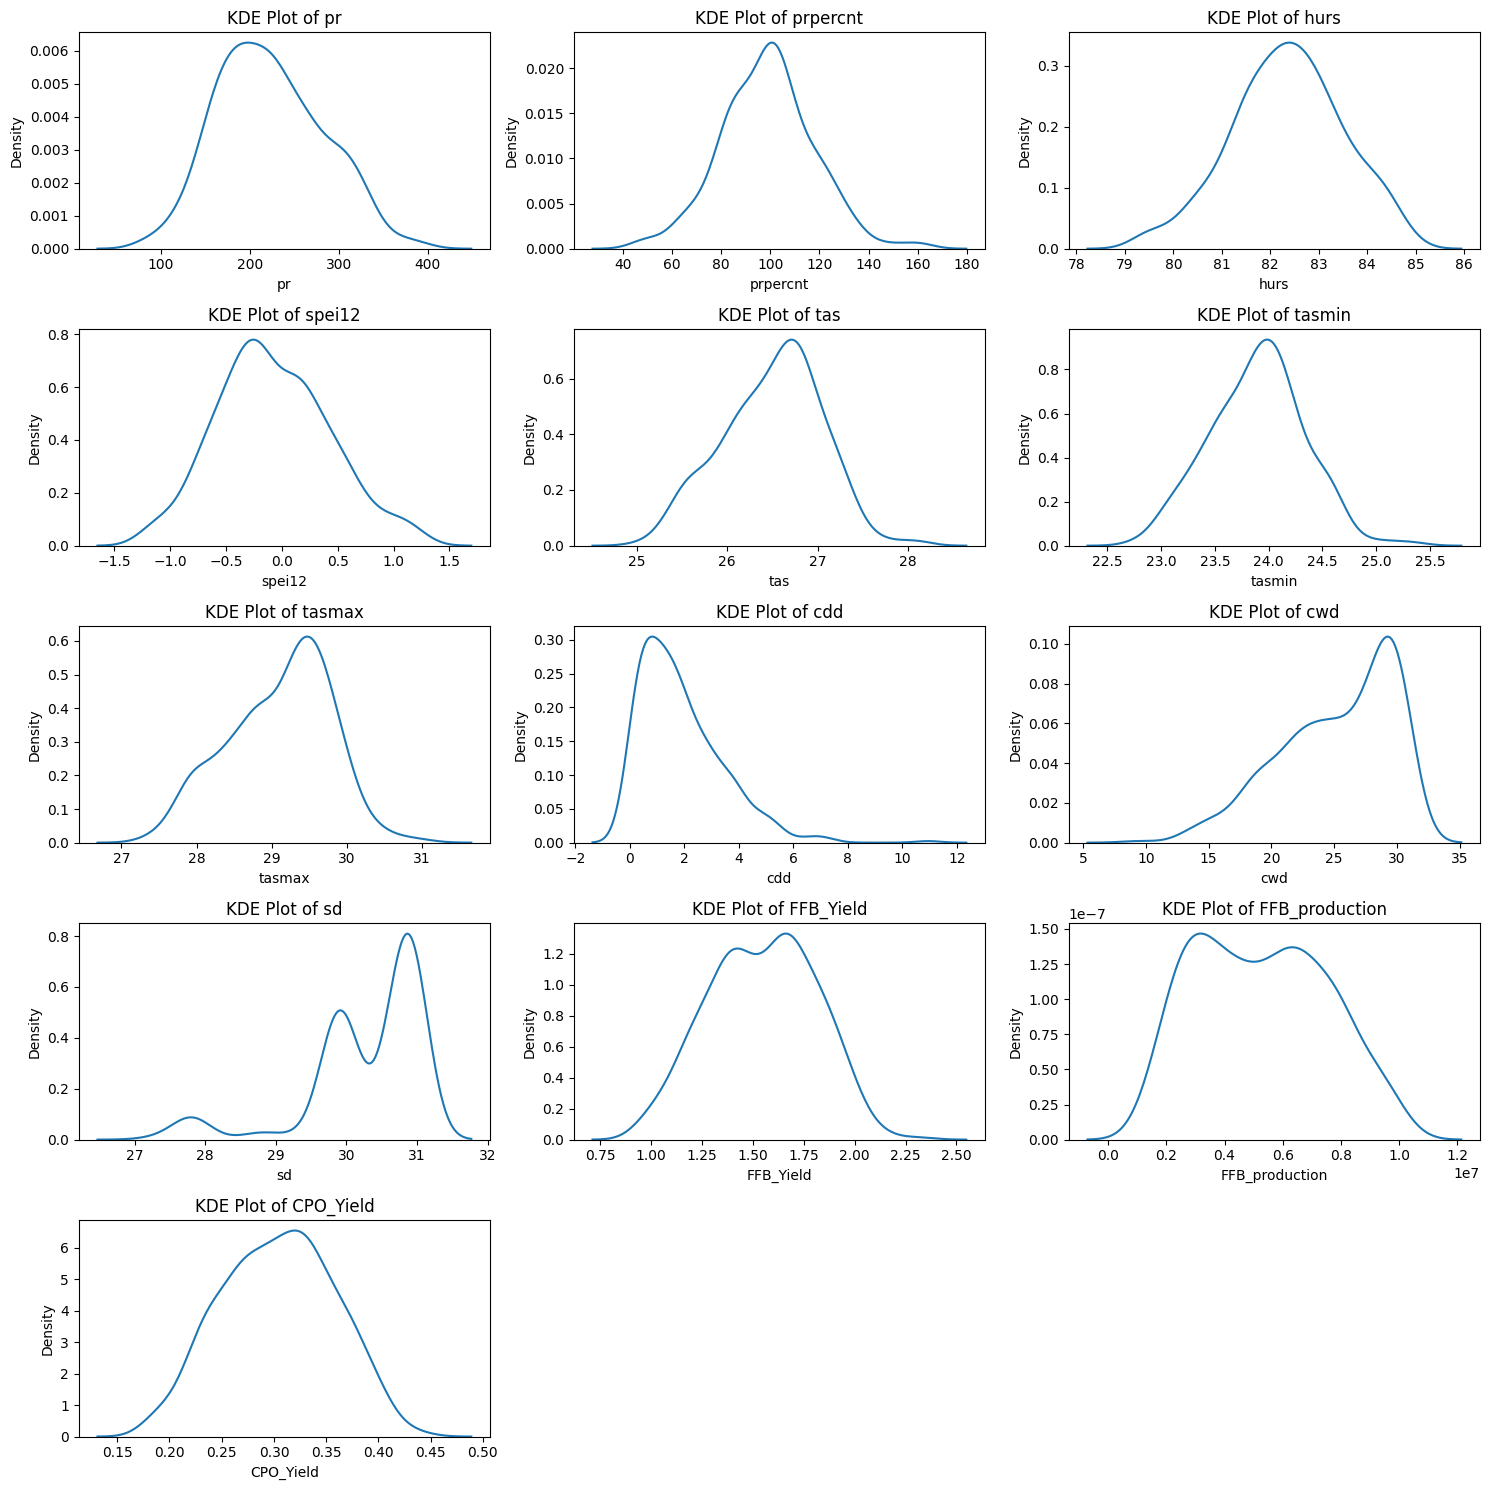

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_to_plot = ['pr', 'prpercnt', 'hurs', 'spei12', 'tas', 'tasmin', 'tasmax', 'cdd', 'cwd', 'sd', 'FFB_Yield', 'FFB_production', 'CPO_Yield']

num_plots = len(variables_to_plot)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(15, 3 * num_rows))

for i, variable in enumerate(variables_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.kdeplot(data_lag[variable])
    plt.title(f'KDE Plot of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

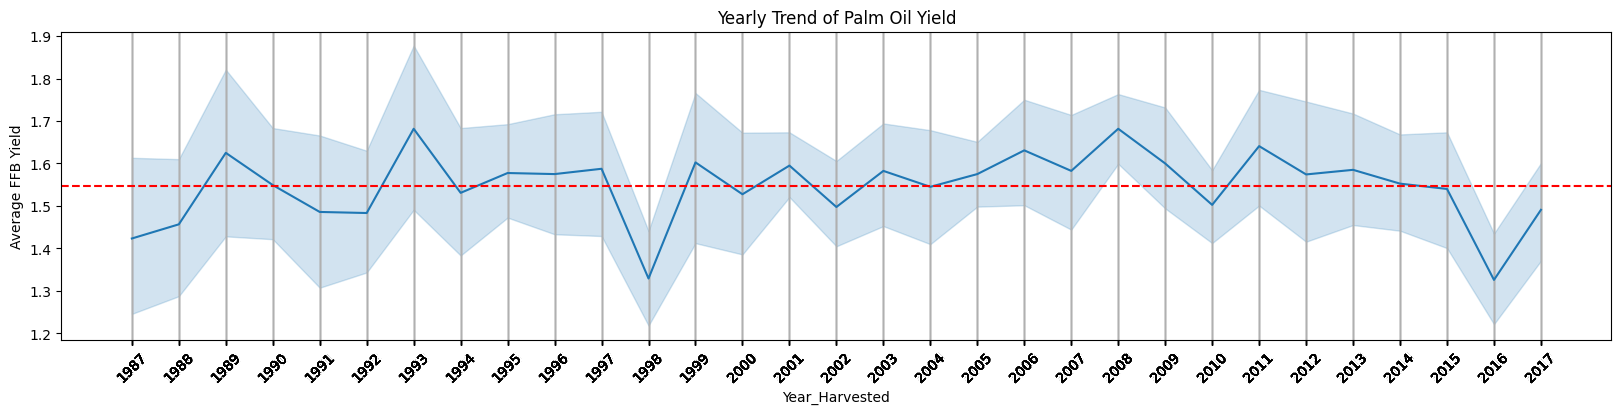

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'palm_oil' DataFrame has a 'Year' and 'Yield' column
# palm_oil_yearly = palm_oil.groupby('Year')['FFB_Yield'].mean().reset_index()
# subset palmoil
baseline_value = data_lag['FFB_Yield'].mean()


plt.figure(figsize=(20, 4))
sns.lineplot(data=data_lag, x='Year_Harvested', y='FFB_Yield')
plt.axhline(y=baseline_value, color='r', linestyle='--', label='Baseline')
plt.xlabel('Year_Harvested')
plt.xticks(data_lag['Year_Harvested'], rotation=45)
plt.ylabel('Average FFB Yield')
plt.title('Yearly Trend of Palm Oil Yield')
plt.grid(axis='x')
plt.show()

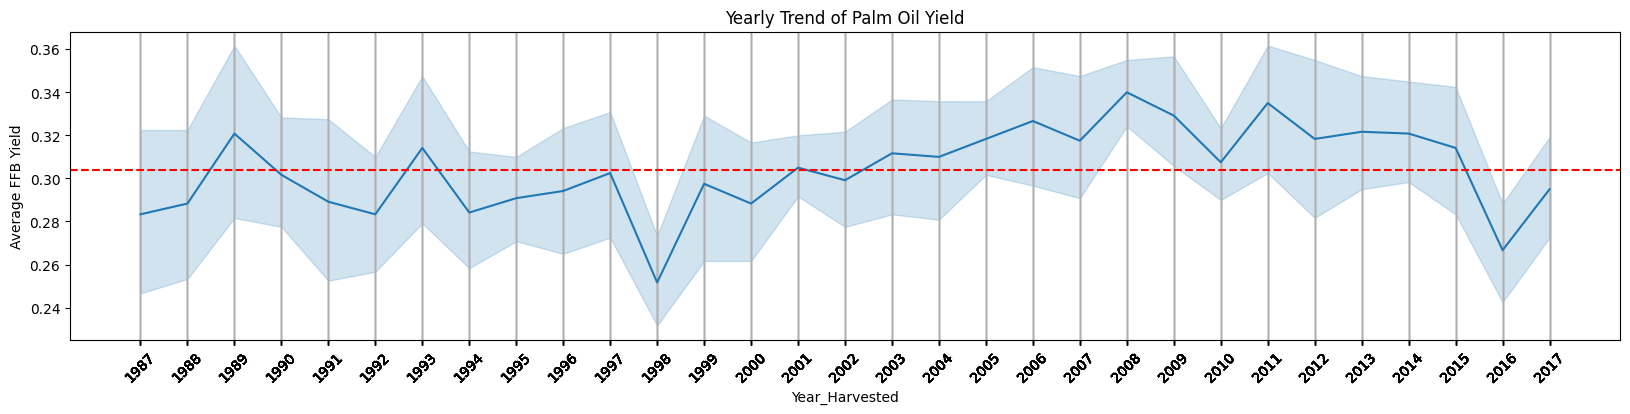

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'palm_oil' DataFrame has a 'Year' and 'Yield' column
# palm_oil_yearly = palm_oil.groupby('Year')['FFB_Yield'].mean().reset_index()
# subset palmoil
baseline_value = data_lag['CPO_Yield'].mean()


plt.figure(figsize=(20, 4))
sns.lineplot(data=data_lag, x='Year_Harvested', y='CPO_Yield')
plt.axhline(y=baseline_value, color='r', linestyle='--', label='Baseline')
plt.xlabel('Year_Harvested')
plt.xticks(data_lag['Year_Harvested'], rotation=45)
plt.ylabel('Average FFB Yield')
plt.title('Yearly Trend of Palm Oil Yield')
plt.grid(axis='x')
plt.show()

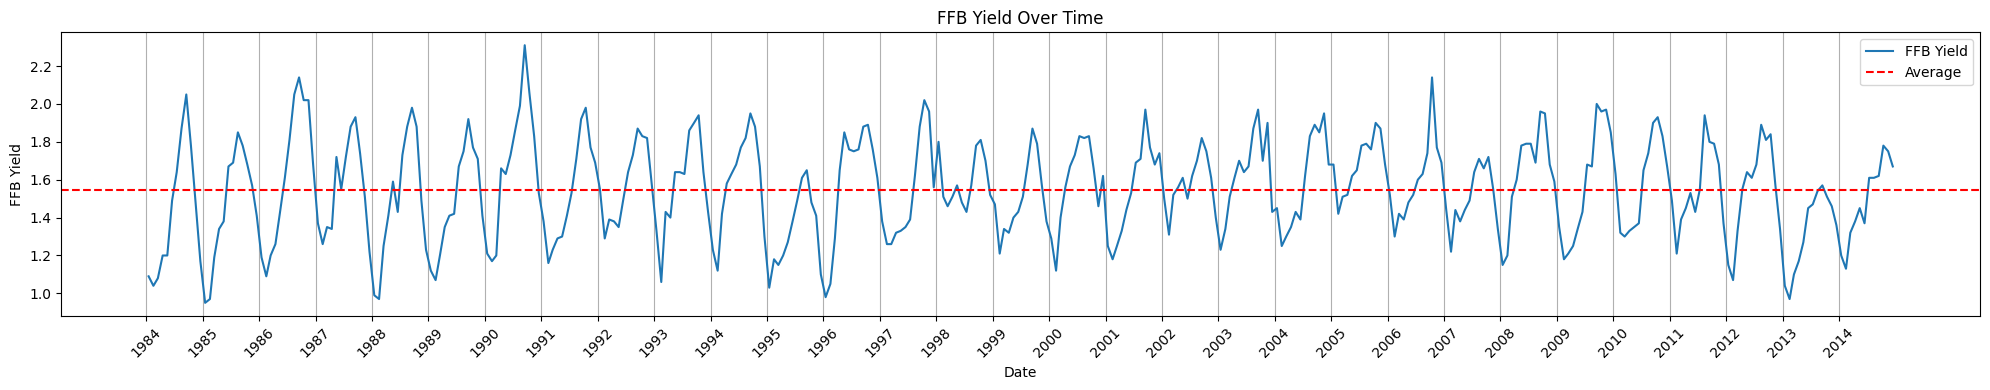

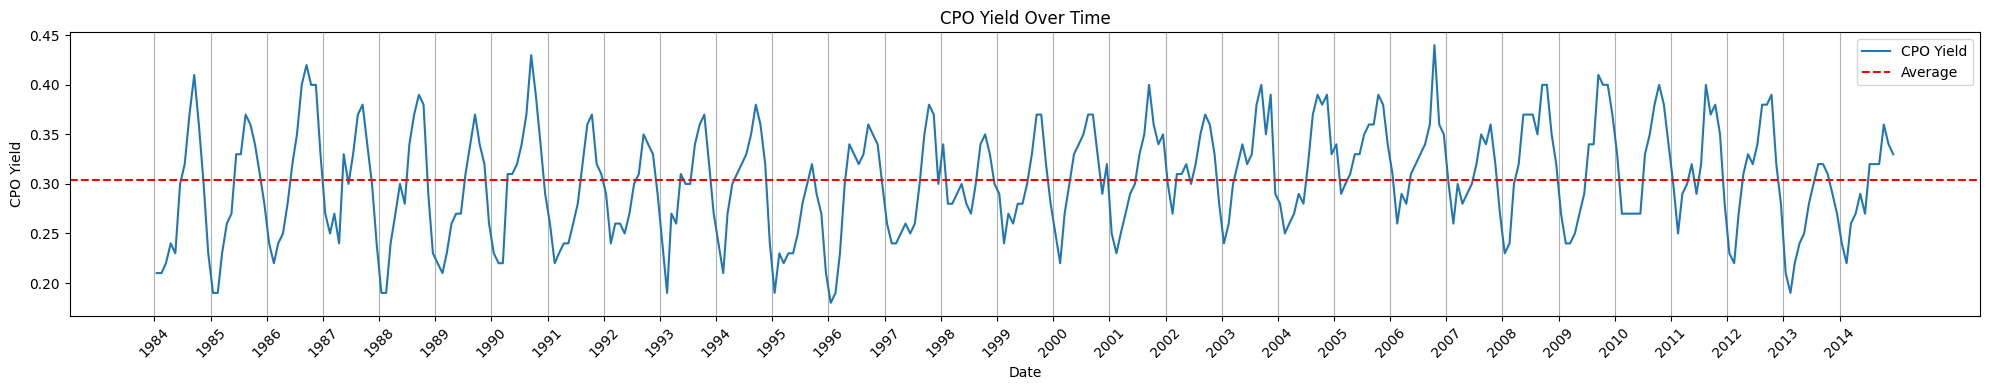

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate baseline

# Sort data by date and ensure datetime conversion
data = data_lag.sort_values(by='Date')
data['Date'] = pd.to_datetime(data['Date'])
baseline_ffb = data['FFB_Yield'].mean()

# Plot FFB Yield against Date
plt.figure(figsize=(20, 4))
sns.lineplot(data=data, x='Date', y='FFB_Yield', label='FFB Yield')
plt.axhline(y=baseline_ffb, color='r', linestyle='--', label='Average')

# Set x-axis ticks to display all years
years = data['Date'].dt.year.unique()  # Extract unique years
plt.xticks(
    ticks=pd.to_datetime(years, format='%Y'),  # Convert to datetime format
    labels=years,  # Use years as labels
    rotation=45
)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('FFB Yield')
plt.title('FFB Yield Over Time')
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()


baseline_cpo = data['CPO_Yield'].mean()

# Plot FFB Yield against Date
plt.figure(figsize=(20, 4))
sns.lineplot(data=data, x='Date', y='CPO_Yield', label='CPO Yield')
plt.axhline(y=baseline_cpo, color='r', linestyle='--', label='Average')

# Set x-axis ticks to display all years
years = data['Date'].dt.year.unique()  # Extract unique years
plt.xticks(
    ticks=pd.to_datetime(years, format='%Y'),  # Convert to datetime format
    labels=years,  # Use years as labels
    rotation=45
)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('CPO Yield')
plt.title('CPO Yield Over Time')
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()



In [ ]:
monthly_avg_ffb = data_lag.groupby('Month')['FFB_Yield'].mean().reset_index()
monthly_avg_ffb

Month  FFB_Yield
0       1   1.304516
1       2   1.181613
2       3   1.320968
3       4   1.407742
4       5   1.498387
5       6   1.530000
6       7   1.649677
7       8   1.766774
8       9   1.874516
9      10   1.832258
10     11   1.697742
11     12   1.491935

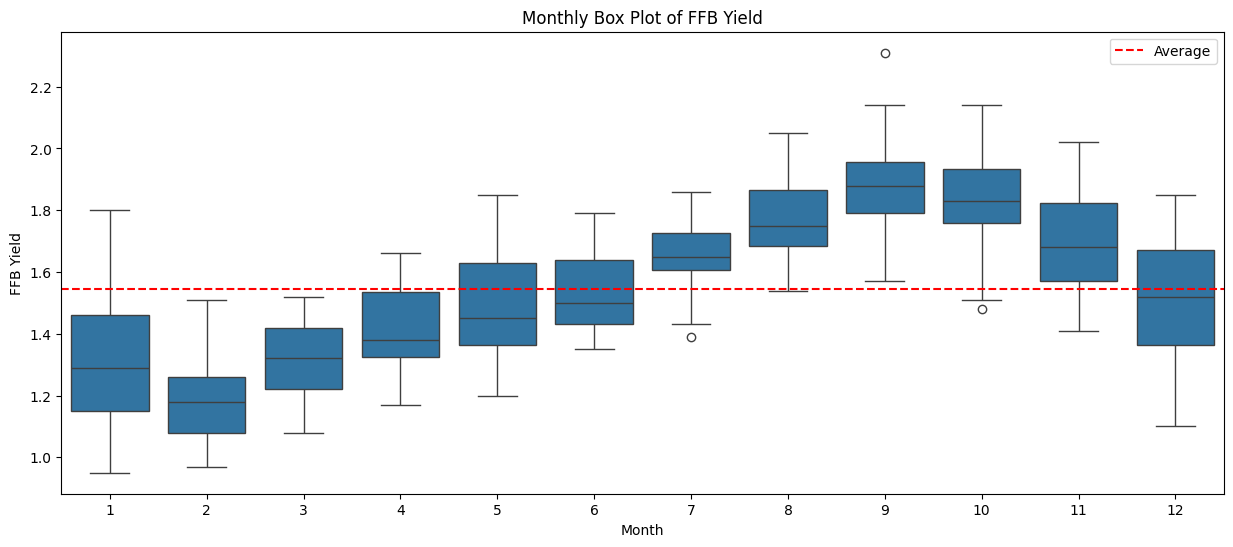

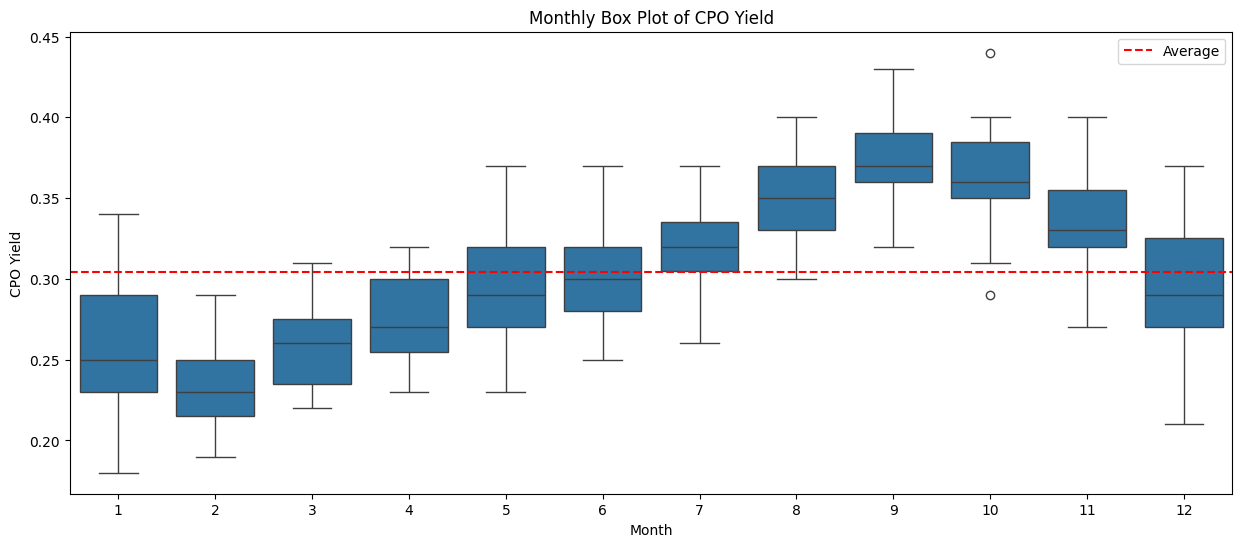

In [ ]:
# prompt: visualise monthly yield patterns using box plots

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data_lag' DataFrame is already loaded and processed

# Create box plots for monthly yield patterns
baseline_ffb = data_lag['FFB_Yield'].mean()
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month', y='FFB_Yield', data=data_lag)
plt.axhline(y=baseline_ffb, color='r', linestyle='--', label='Average')
plt.title('Monthly Box Plot of FFB Yield')
plt.xlabel('Month')
plt.ylabel('FFB Yield')
plt.legend()

plt.show()

baseline_cpo = data_lag['CPO_Yield'].mean()
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month', y='CPO_Yield', data=data_lag)
plt.axhline(y=baseline_cpo, color='r', linestyle='--', label='Average')
plt.title('Monthly Box Plot of CPO Yield')
plt.xlabel('Month')
plt.ylabel('CPO Yield')
plt.legend()

plt.show()

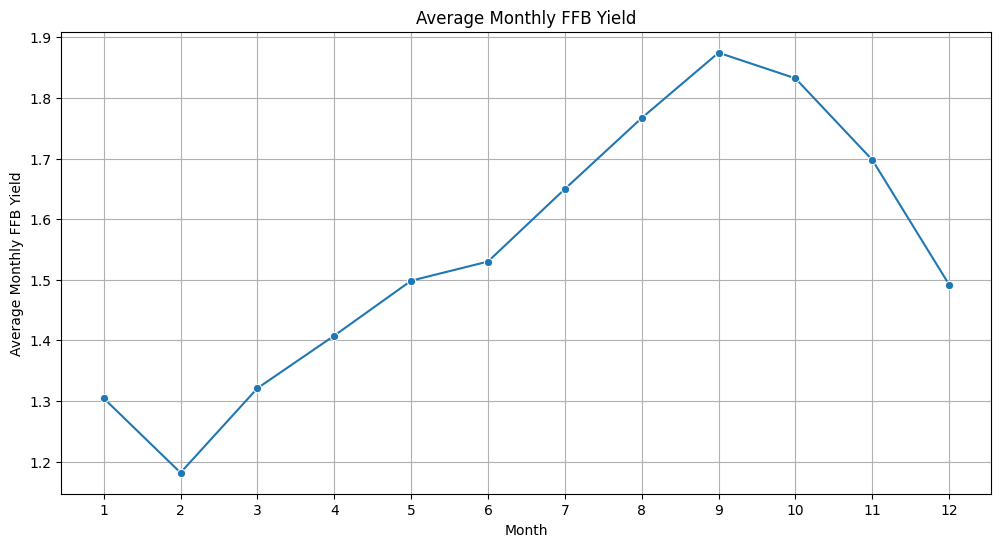

In [ ]:
# prompt: average monthly yield line plot

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data_lag' DataFrame is already loaded and processed

# Calculate monthly average FFB yield
monthly_avg_ffb = data_lag.groupby('Month')['FFB_Yield'].mean().reset_index()

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='FFB_Yield', data=monthly_avg_ffb, marker='o')
plt.xlabel('Month')
plt.ylabel('Average Monthly FFB Yield')
plt.title('Average Monthly FFB Yield')
plt.xticks(range(1, 13))  # Ensure all months are displayed on the x-axis
plt.grid(True)
plt.show()

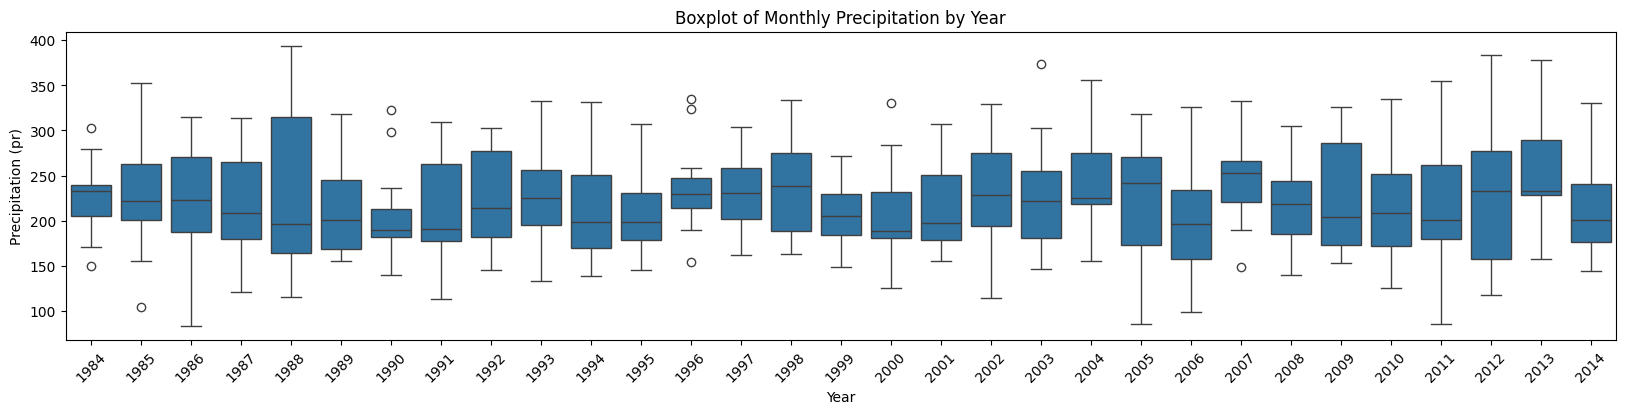

In [ ]:
# prompt: boxplot of pr by year
plt.figure(figsize=(20, 4))
sns.boxplot(x='Year_Climate', y='pr', data=data_lag)
plt.xlabel('Year')
plt.ylabel('Precipitation (pr)')
plt.title('Boxplot of Monthly Precipitation by Year')
plt.xticks(rotation=45)
plt.show()

2673.9565803225805


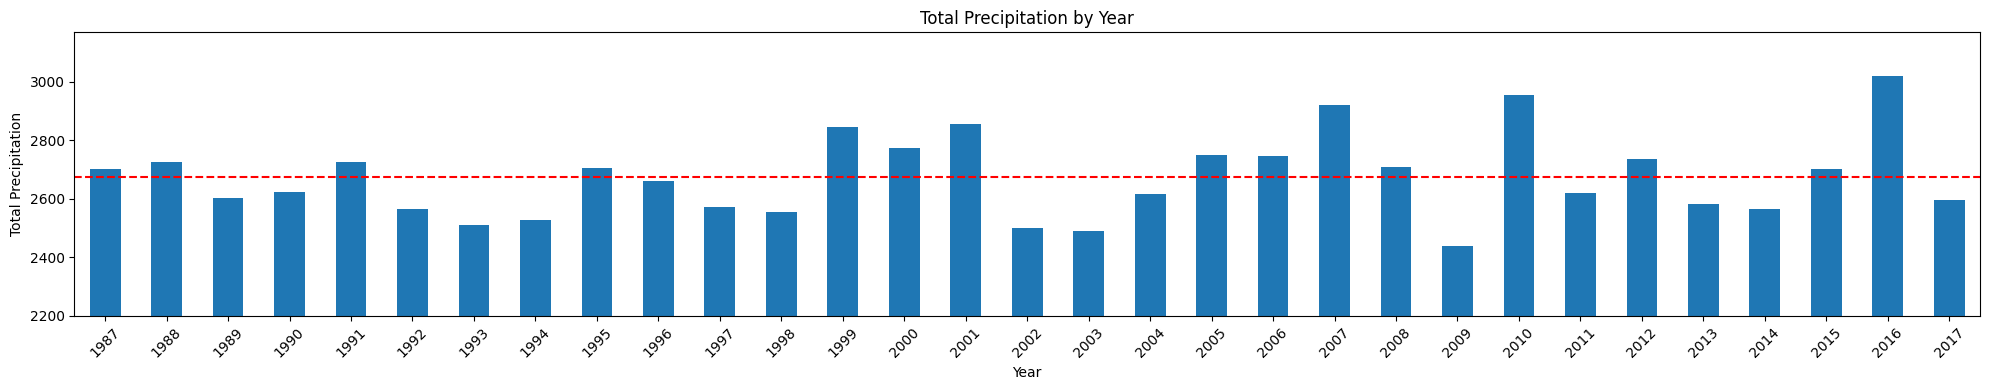

In [ ]:
# prompt: total percipitation by year

# Group the data by year and calculate the total precipitation for each year
yearly_precipitation = data_lag.groupby('Year_Harvested')['pr'].sum()
baseline = yearly_precipitation.mean()
print(baseline)

# Create a bar plot of total precipitation per year
plt.figure(figsize=(20, 4))
yearly_precipitation.plot(kind='bar')
plt.axhline(y=baseline, color='r', linestyle='--', label='Baseline')
plt.xlabel('Year')
plt.ylabel('Total Precipitation')
plt.title('Total Precipitation by Year')
plt.xticks(rotation=45)
plt.ylim(bottom=2200)
plt.tight_layout()
plt.show()

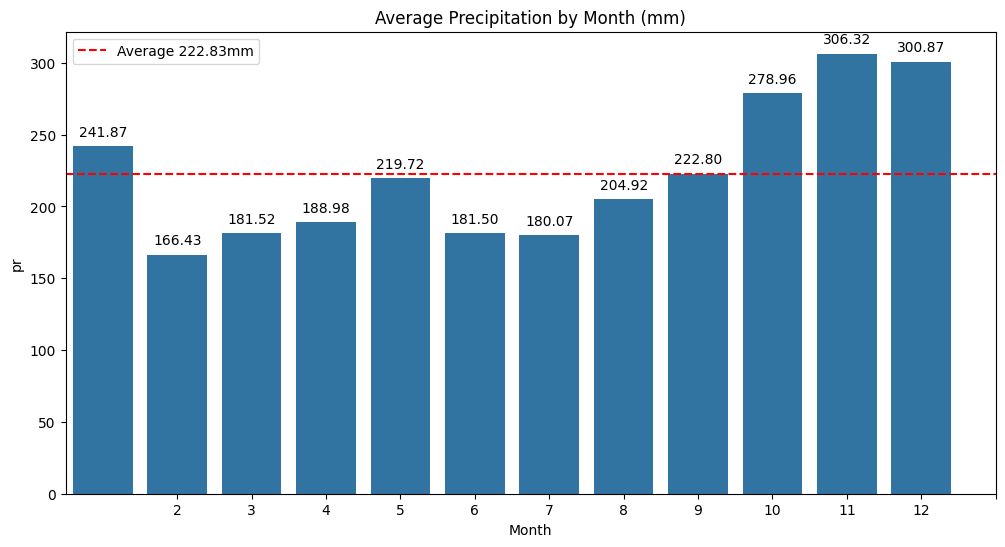

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate monthly average precipitation
monthly_avg_pr = data_lag.groupby('Month')['pr'].mean().reset_index()
baseline = monthly_avg_pr['pr'].mean()

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Month', y='pr', data=monthly_avg_pr)  # Store the axis object
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Average {baseline:.2f}mm')
plt.xlabel('Month')
plt.title('Average Precipitation by Month (mm)')
plt.xticks(range(1, 13))  # Ensure all months are displayed on the x-axis
plt.legend()

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

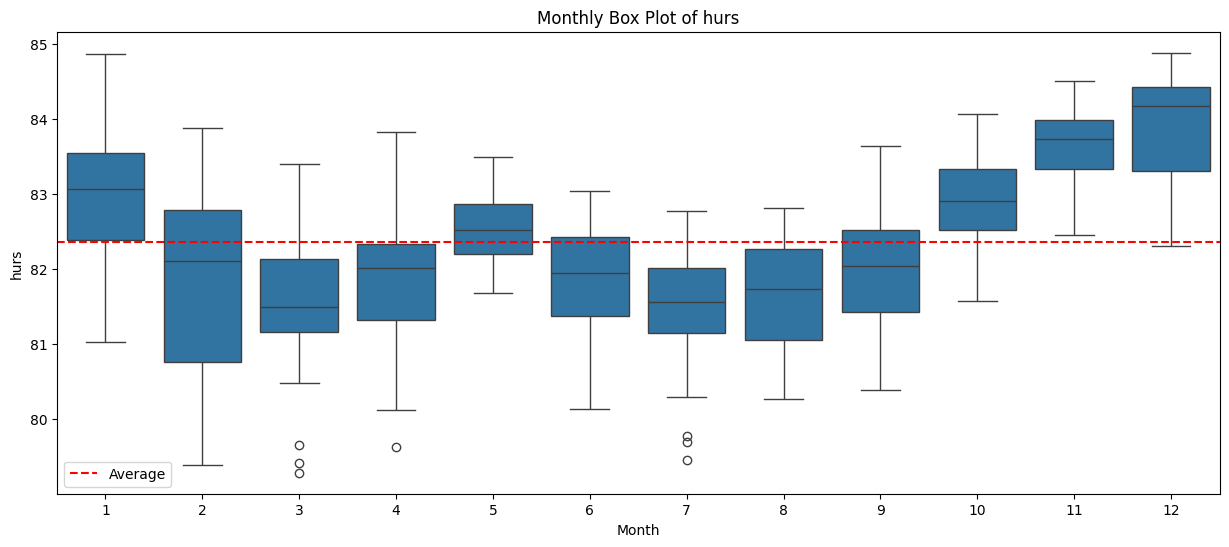

In [ ]:
baseline = data_lag['hurs'].mean()

plt.figure(figsize=(15, 6))
sns.boxplot(x='Month', y='hurs', data=data_lag)
plt.axhline(y=baseline, color='r', linestyle='--', label='Average')
plt.title('Monthly Box Plot of hurs')
plt.xlabel('Month')
plt.ylabel('hurs')
plt.legend()

plt.show()

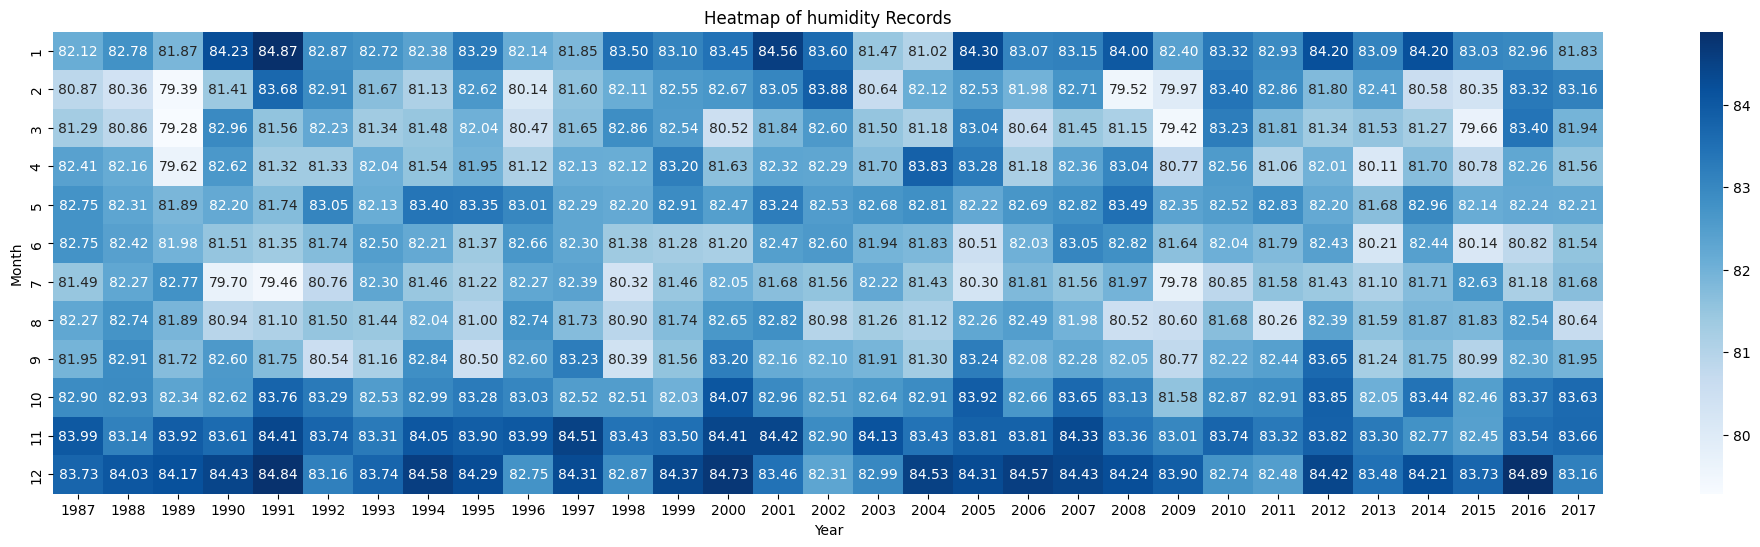

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))
sns.heatmap(data_lag.pivot_table(index='Month', columns='Year_Harvested', values='hurs'), annot=True, fmt=".2f", cmap="Blues")
plt.title('Heatmap of humidity Records')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

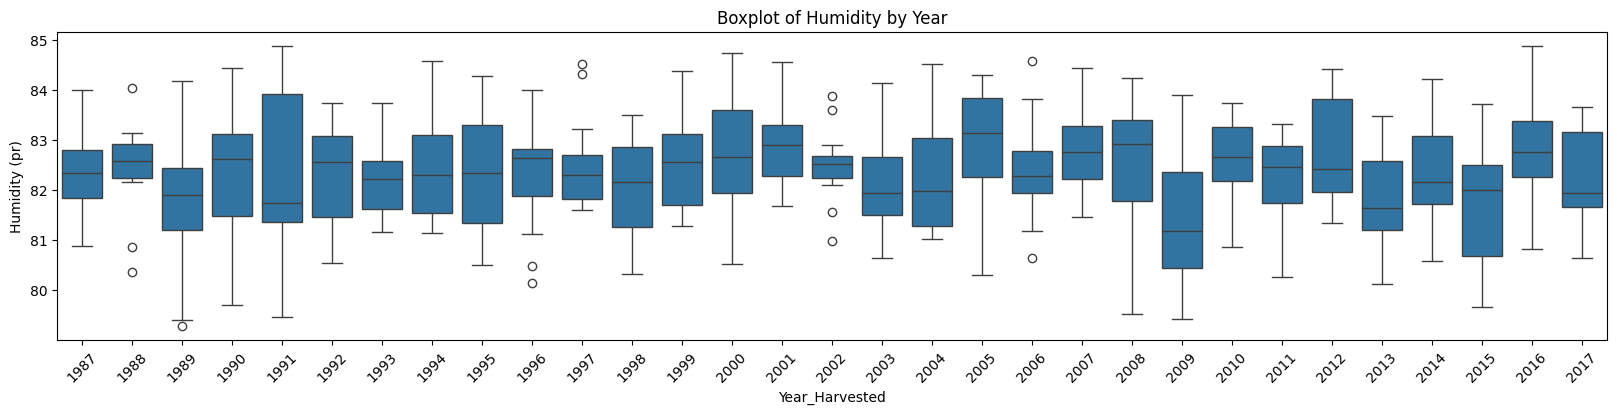

In [ ]:
plt.figure(figsize=(20, 4))
sns.boxplot(x='Year_Harvested', y='hurs', data=data_lag)
plt.xlabel('Year_Harvested')
plt.ylabel('Humidity (pr)')
plt.title('Boxplot of Humidity by Year')
plt.xticks(rotation=45)
plt.show()

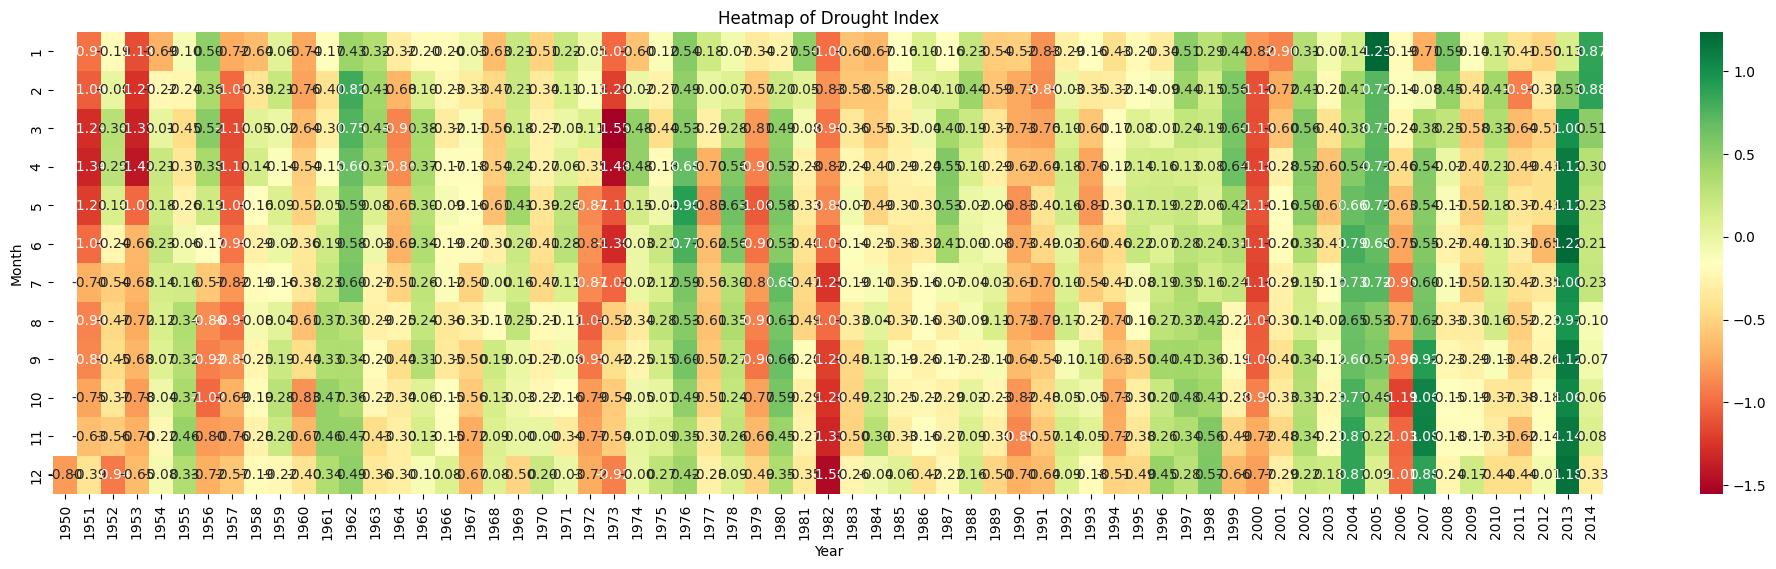

In [ ]:
# prompt: heatplot of year by month value is tas

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))
sns.heatmap(data_lag.pivot_table(index='Month', columns='Year', values='spei12'), annot=True, fmt=".2f", cmap="RdYlGn")
plt.title('Heatmap of Drought Index')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

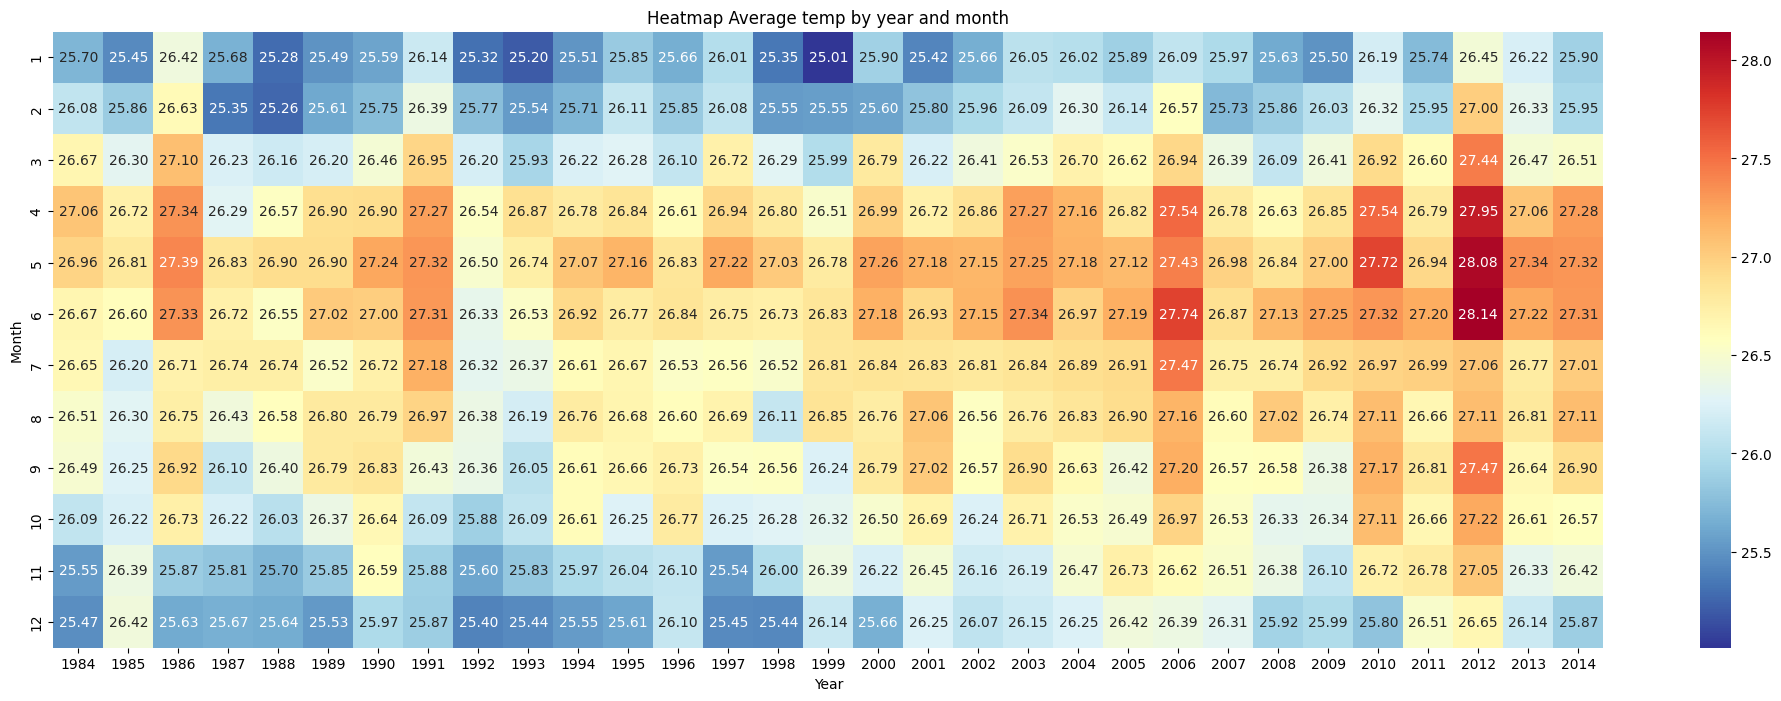

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 8))
sns.heatmap(data_lag.pivot_table(index='Month', columns='Year_Climate', values='tas'), annot=True, fmt=".2f", cmap="RdYlBu_r")
plt.title('Heatmap Average temp by year and month')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

In [ ]:
yearly_temp = historical_climate.groupby('Year')['tas'].mean()


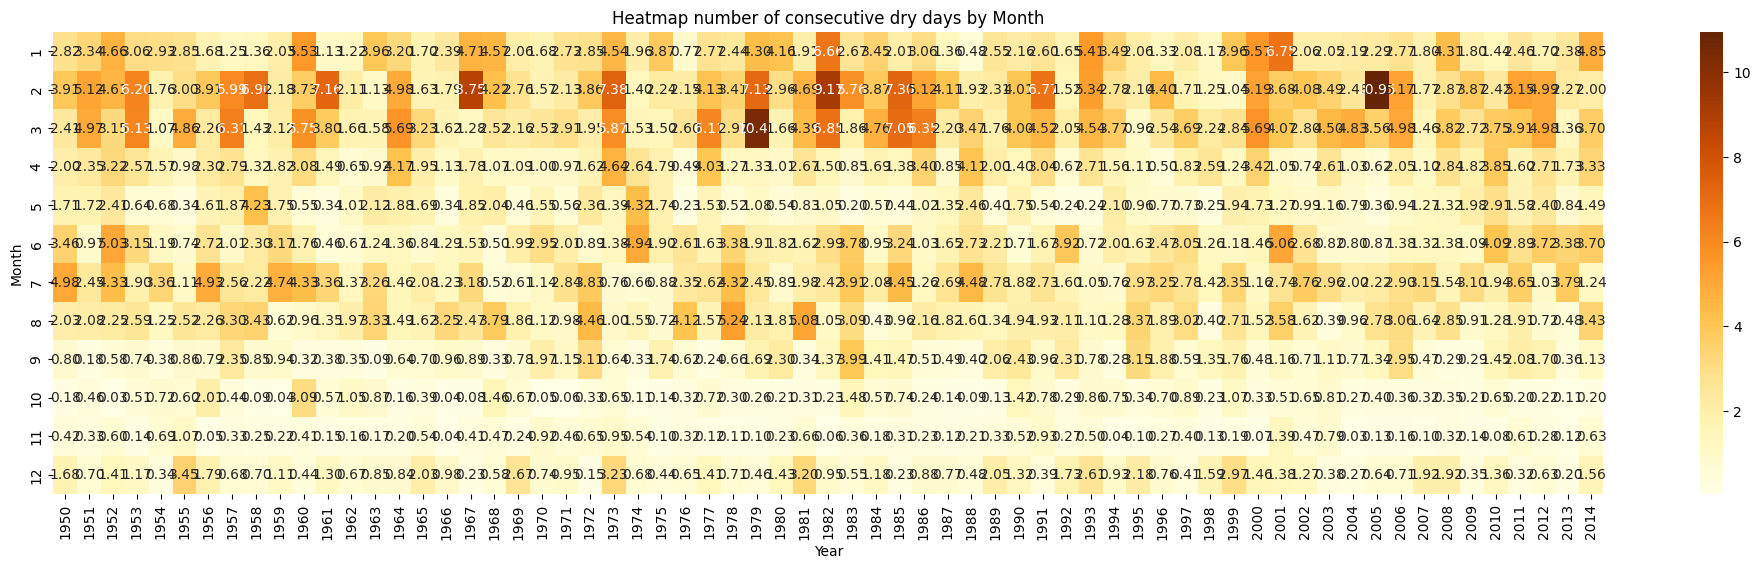

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))
sns.heatmap(data_lag.pivot_table(index='Month', columns='Year', values='cdd'), annot=True, fmt=".2f", cmap="YlOrBr")
plt.title('Heatmap number of consecutive dry days by Month')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

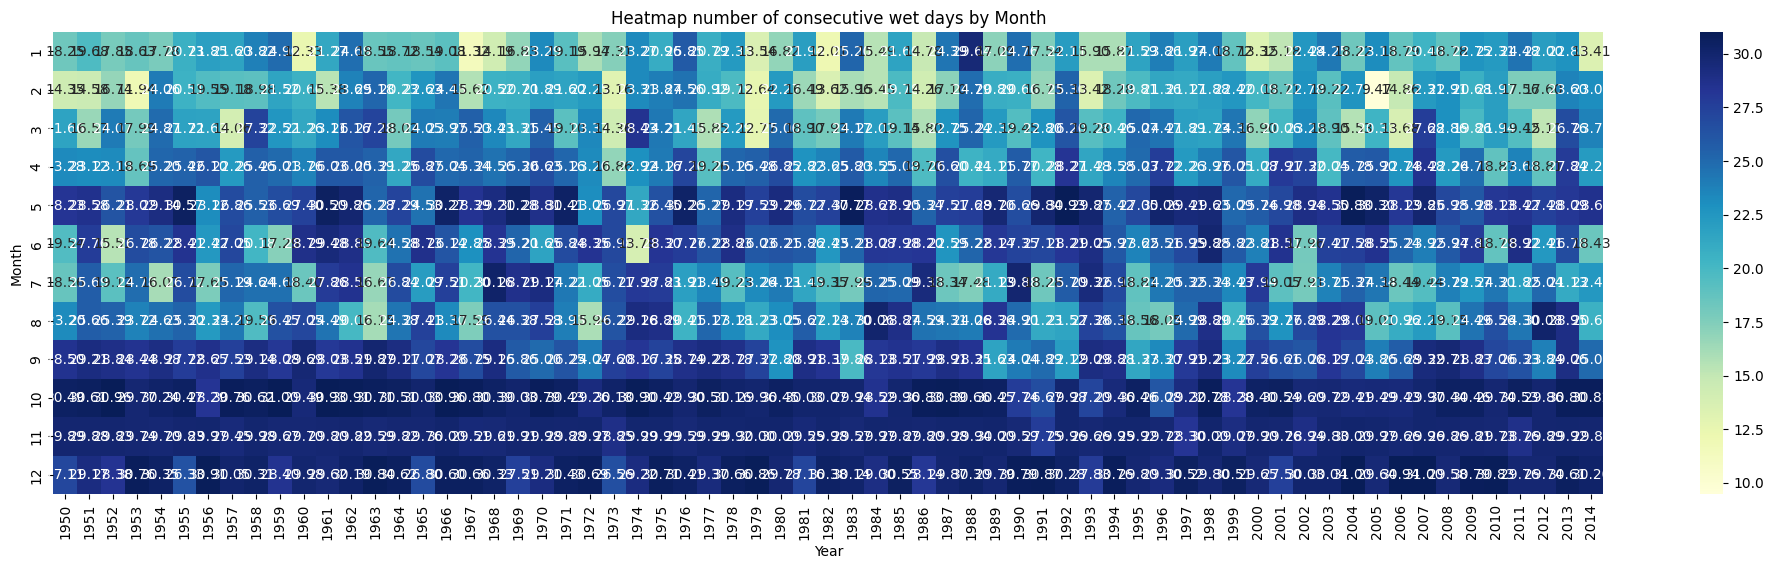

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))
sns.heatmap(data_lag.pivot_table(index='Month', columns='Year', values='cwd'), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap number of consecutive wet days by Month')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()

In [ ]:
data_lag.describe()

Year_Climate       Month                           Date          pr  \
count    372.000000  372.000000                            372  372.000000   
mean    1999.000000    6.500000  1999-07-01 20:15:29.032258048  222.829715   
min     1984.000000    1.000000            1984-01-16 00:00:00   83.373055   
25%     1991.000000    3.750000            1991-10-08 12:00:00  179.003112   
50%     1999.000000    6.500000            1999-07-01 00:00:00  218.090425   
75%     2007.000000    9.250000            2007-03-23 18:00:00  264.940105   
max     2014.000000   12.000000            2014-12-16 00:00:00  394.044680   
std        8.956318    3.456702                            NaN   59.606571   

         prpercnt        hurs      spei12         tas      tasmin      tasmax  \
count  372.000000  372.000000  372.000000  372.000000  372.000000  372.000000   
mean    98.919030   82.355433   -0.075109   26.499710   23.895222   29.104198   
min     45.070360   79.281944   -1.188180   25.011980   22.718649   27.305319   
25%     86.501638   81.577185   -0.418341   26.106200   23.599603   28.621465   
50%     99.476948   82.367793   -0.139086   26.564768   23.922649   29.239998   
75%    109.738812   83.135569    0.237094   26.863108   24.175253   29.595472   
max    162.384340   84.887695    1.234807   28.144142   25.388315   31.033249   
std     18.908860    1.148340    0.502137    0.548060    0.440187    0.678539   

       ...         cwd          sd  Year_Harvested   FFB_Yield  \
count  ...  372.000000  372.000000      372.000000  372.000000   
mean   ...   25.235515   30.280730     2002.000000    1.546344   
min    ...    9.469703   27.242442     1987.000000    0.950000   
25%    ...   22.119255   29.913872     1994.000000    1.350000   
50%    ...   26.017713   30.706337     2002.000000    1.555000   
75%    ...   29.326436   30.899925     2010.000000    1.740000   
max    ...   31.000000   31.000000     2017.000000    2.310000   
std    ...    4.504071    0.838166        8.956318    0.259910   

       FFB_production   CPO_Yield   tas_range  rolling_pr_3y  rolling_pr_2y  \
count    3.720000e+02  372.000000  372.000000     372.000000     372.000000   
mean     5.272846e+06    0.304086    5.208976    7988.688025    5340.500806   
min      1.342798e+06    0.180000    4.347259    7485.203352    4867.957220   
25%      3.285593e+06    0.270000    4.972045    7812.168738    5202.935967   
50%      5.186810e+06    0.300000    5.277792    7951.036765    5330.808073   
75%      7.023259e+06    0.340000    5.442715    8194.159750    5458.953631   
max      1.008588e+07    0.440000    5.867093    8475.250420    5859.595160   
std      2.241425e+06    0.053235    0.326925     229.406375     204.433800   

       rolling_pr_1y  
count     372.000000  
mean     2672.733842  
min      2328.151860  
25%      2566.248031  
50%      2653.784145  
75%      2763.780215  
max      3120.930580  
std       148.884852  

[8 rows x 21 columns]

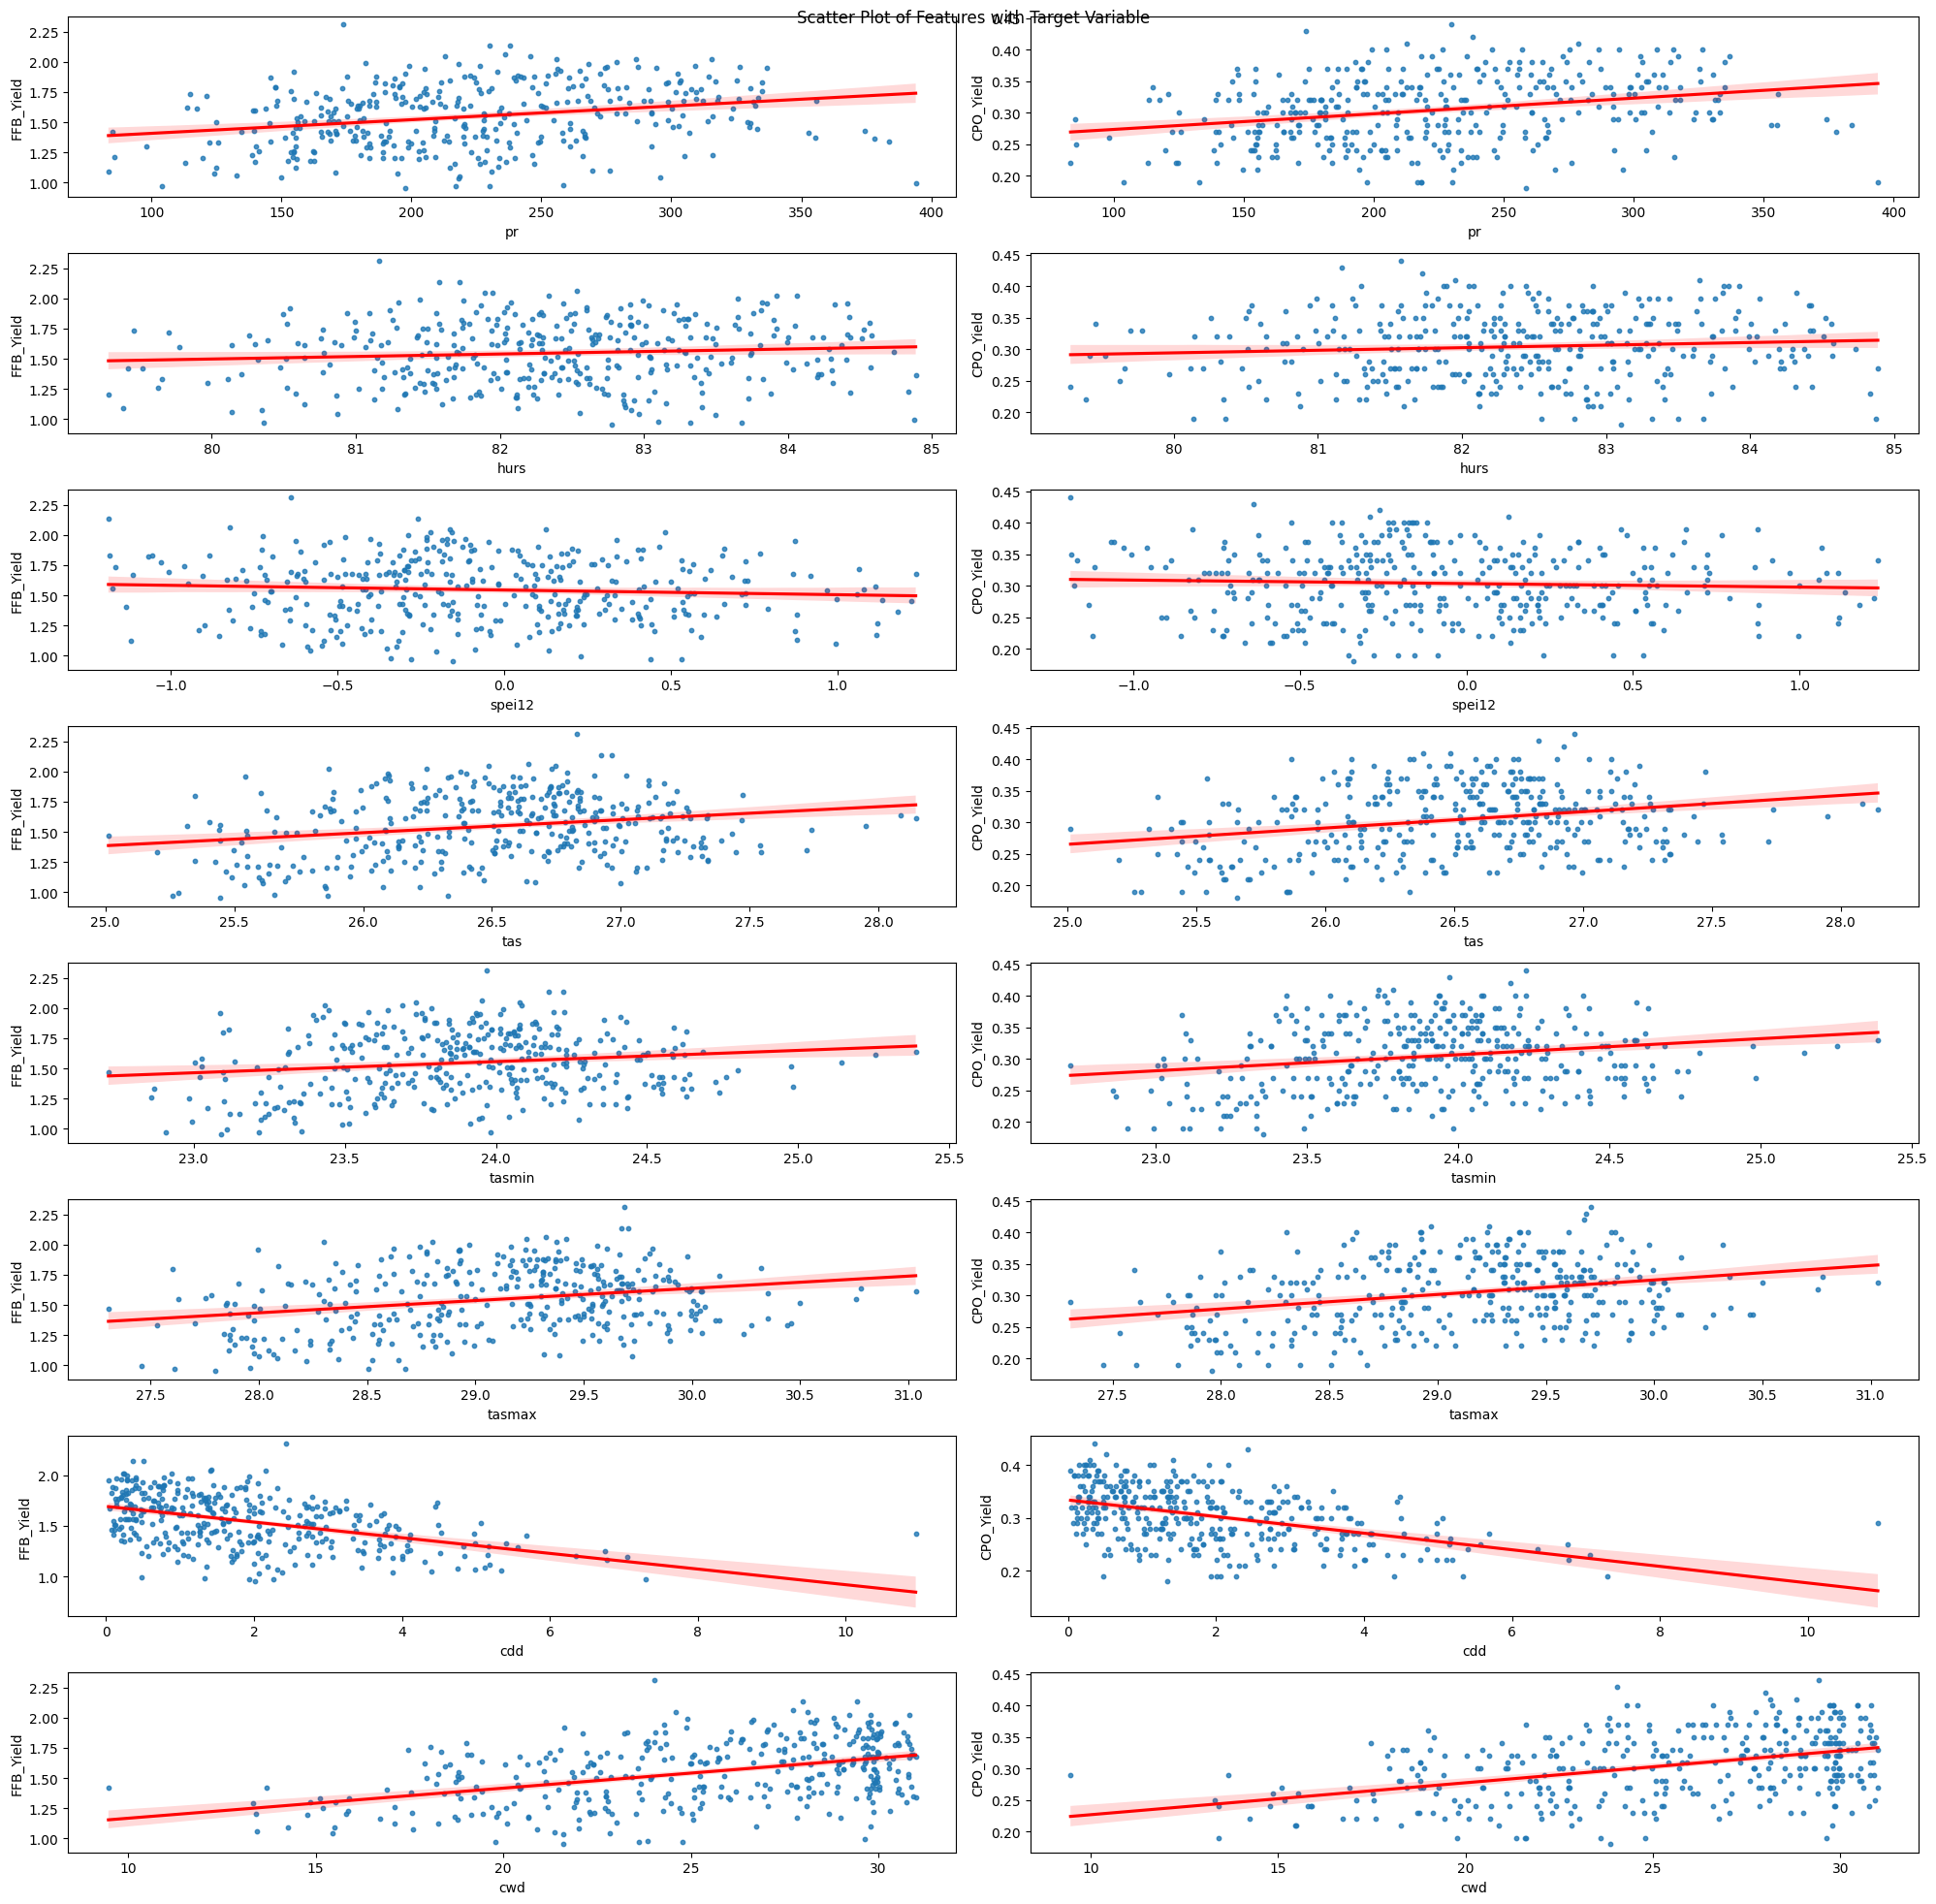

In [ ]:
climate_features = ['pr', 'hurs', 'spei12', 'tas', 'tasmin', 'tasmax', 'cdd', 'cwd']
target = ['FFB_Yield','CPO_Yield']

import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(len(climate_features), len(target), figsize=(20, 20))
fig.suptitle('Scatter Plot of Features with Target Variable')

for i, target_var in enumerate(climate_features):
    for j, feature in enumerate(target):
        sns.regplot(ax=axes[i, j], x=data_lag[target_var], y=data_lag[feature], scatter_kws={'s': 10}, line_kws={'color': 'red'})
        axes[i, j].set_ylabel(feature)
        axes[i, j].set_xlabel(target_var)

plt.tight_layout()
plt.show()

In [ ]:
data_lag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, 408 to 779
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Year_Climate    372 non-null    int64         
 1   Month           372 non-null    int64         
 2   Date            372 non-null    datetime64[ns]
 3   pr              372 non-null    float64       
 4   prpercnt        372 non-null    float64       
 5   hurs            372 non-null    float64       
 6   spei12          372 non-null    float64       
 7   tas             372 non-null    float64       
 8   tasmin          372 non-null    float64       
 9   tasmax          372 non-null    float64       
 10  cdd             372 non-null    float64       
 11  cwd             372 non-null    float64       
 12  sd              372 non-null    float64       
 13  Year_Harvested  372 non-null    int64         
 14  FFB_Yield       372 non-null    float64       
 15  FFB_produ

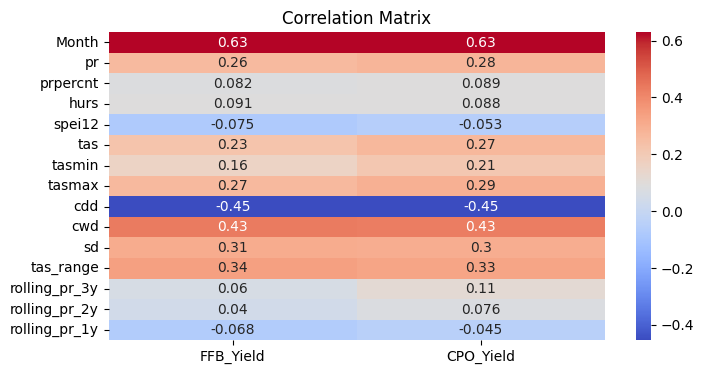

In [ ]:
target = ['FFB_Yield','CPO_Yield']
climate_features = data_lag.drop(target, axis=1).columns
time_features = ['Year_Climate', 'Year_Harvested', 'Date']

correlation = data_lag.corr()
correlation = correlation[target]
correlation = correlation.drop(target + time_features + ['FFB_production'], axis=0)

plt.figure(figsize=(8, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Modelling

In [ ]:
# define variables and target
from sklearn.model_selection import train_test_split

X = data_lag.drop(columns=['FFB_Yield', 'FFB_production',
                           'CPO_Yield', 'Year_Climate',
                           'Year_Harvested', 'Date'])
y = data_lag['FFB_Yield']

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_sscaled = scaler.fit_transform(X)

# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

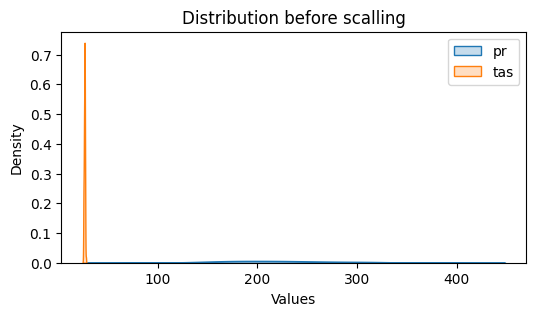

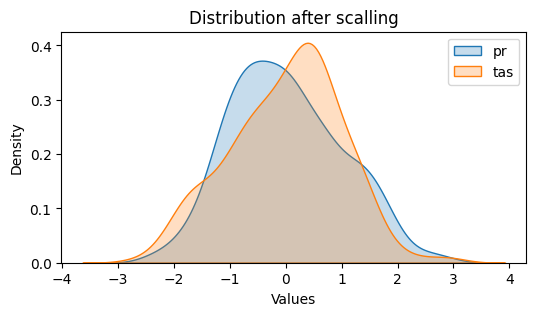

In [ ]:
# kde of all features in one graph
import seaborn as sns
import matplotlib.pyplot as plt

# data = data_lag.drop(['Year_Climate', 'Year_Harvested', 'FFB_Yield', 'FFB_production', 'CPO_Yield', 'rolling_pr_3y'], axis=1)
data = data_lag[['pr', 'tas']]

# Plot KDE of all features
plt.figure(figsize=(6,3))
for feature in data.columns:
    sns.kdeplot(data[feature], label=feature, fill=True)
plt.title('Distribution before scalling')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

# kde of all features in one graph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

ss_scaler = StandardScaler()

# data = data_lag.drop(['Year_Climate', 'Year_Harvested', 'FFB_Yield', 'FFB_production', 'CPO_Yield', 'rolling_pr_3y'], axis=1)
data = data_lag[['pr', 'tas']]

data = pd.DataFrame(ss_scaler.fit_transform(data), columns=data.columns)

# Plot KDE of all features
plt.figure(figsize=(6,3))
for feature in data.columns:
    sns.kdeplot(data[feature], label=feature, fill=True)
plt.title('Distribution after scalling')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



# method to train and append model results to the results table
trained_models = {}
def train_and_append_results(model, resultstable, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Perform cross-validation and calculate evaluation metrics
    mse_scores = cross_val_score(pipeline, X_train, y_train, cv=kf,
                                 scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-mse_scores)
    r2_scores = cross_val_score(pipeline, X_train, y_train, cv=kf,
                                scoring='r2')
    mae_scores = cross_val_score(pipeline, X_train, y_train, cv=kf,
                                 scoring='neg_mean_absolute_error')

    # Calculate mean and standard deviation of the scores
    mse_mean = -mse_scores.mean()
    mse_std = mse_scores.std()
    rmse_mean = rmse_scores.mean()
    rmse_std = rmse_scores.std()
    r2_mean = r2_scores.mean()
    r2_std = r2_scores.std()
    mae_mean = -mae_scores.mean()
    mae_std = mae_scores.std()

    # Fit the model to the entire training data
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Append the results to the table
    resultstable.loc[len(resultstable)] = [
        model.__class__.__name__,
        mse_mean, mse_std,
        rmse_mean, rmse_std,
        mae_mean, mae_std,
        r2_mean, r2_std
    ]

    # Store the trained model and predictions
    trained_models[model.__class__.__name__] = {'model': pipeline, 'y_pred': y_pred}

In [ ]:
# define results table
results_ffb = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
results_ffb = pd.DataFrame(columns=['Model', 'MSE Mean', 'MSE Std', 'RMSE Mean', 'RMSE Std', 'MAE Mean', 'MAE Std', 'R2 Mean', 'R2 Std'])

# Define the models
ffb_model_LR = LinearRegression()
ffb_model_DTR = DecisionTreeRegressor(random_state=42)
ffb_model_RFR = RandomForestRegressor(random_state=42)
ffb_model_ABR = AdaBoostRegressor(random_state=42)
ffb_model_ETR = ExtraTreesRegressor(random_state=42)

train_and_append_results(ffb_model_LR, results_ffb)
train_and_append_results(ffb_model_DTR, results_ffb)
train_and_append_results(ffb_model_RFR, results_ffb)
train_and_append_results(ffb_model_ABR, results_ffb)
train_and_append_results(ffb_model_ETR, results_ffb)

results_ffb.sort_values('R2 Mean', ascending=False)

Model  MSE Mean   MSE Std  RMSE Mean  RMSE Std  MAE Mean  \
2  RandomForestRegressor  0.027211  0.002790   0.164736  0.008540  0.134696   
3      AdaBoostRegressor  0.027467  0.001545   0.165667  0.004655  0.134031   
4    ExtraTreesRegressor  0.027987  0.003139   0.167033  0.009322  0.137915   
0       LinearRegression  0.032221  0.003013   0.179304  0.008413  0.142204   
1  DecisionTreeRegressor  0.052856  0.007453   0.229294  0.016753  0.183201   

    MAE Std   R2 Mean    R2 Std  
2  0.007520  0.596725  0.060866  
3  0.003160  0.592507  0.053703  
4  0.007047  0.585158  0.067460  
0  0.009578  0.522610  0.071797  
1  0.013432  0.208523  0.187106

In [ ]:
best_model_name = results_ffb.loc[results_ffb['R2 Mean'].idxmax()]['Model']
best_pipeline = trained_models[best_model_name]['model']
best_model = best_pipeline.named_steps['model']
best_model_metrics = results_ffb[results_ffb['Model'] == best_model_name].iloc[0]  # Get metrics row
best_model_y_pred = trained_models[best_model_name]['y_pred']

print(f"Evaluation Metrics for the Best Model: {best_model_name}")
for metric in ['MSE Mean', 'MSE Std', 'RMSE Mean', 'RMSE Std', 'MAE Mean', 'MAE Std', 'R2 Mean', 'R2 Std']:
    print(f"{metric}: {best_model_metrics[metric]}")

Evaluation Metrics for the Best Model: RandomForestRegressor
MSE Mean: 0.027210729322033916
MSE Std: 0.0027899355955637423
RMSE Mean: 0.16473555497047648
RMSE Std: 0.008539686797712541
MAE Mean: 0.13469600000000007
MAE Std: 0.0075200981752046635
R2 Mean: 0.5967250744867536
R2 Std: 0.060866067456348975


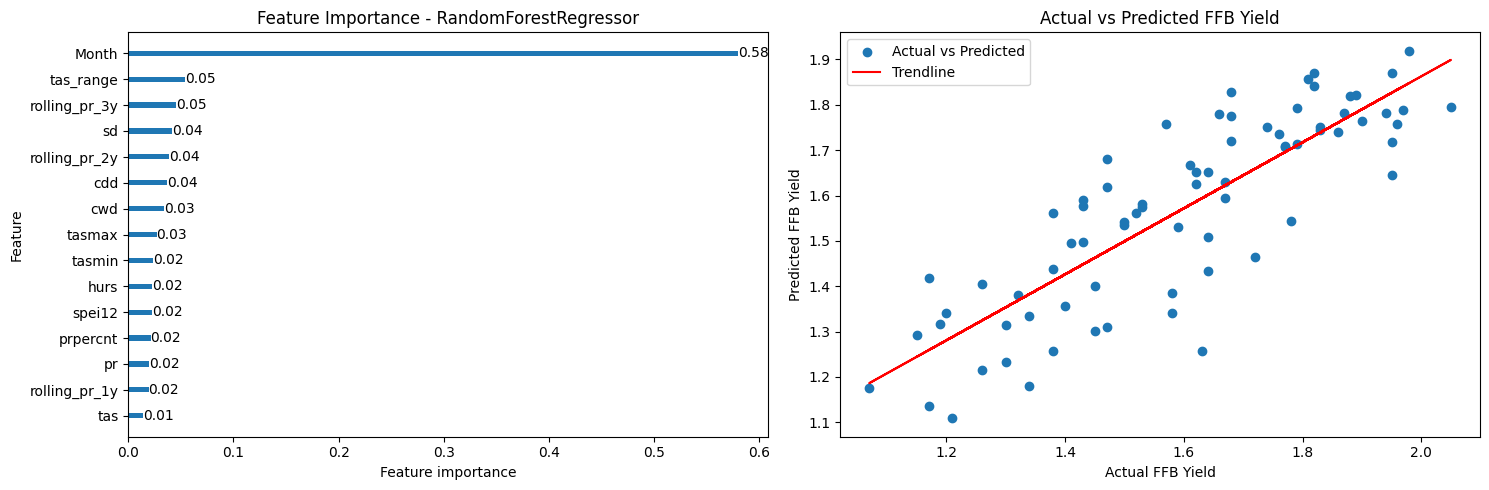

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot feature importance in the first subplot
ax[0].barh(range(X.shape[1]), importances[indices], align="center", height=0.2)
ax[0].set_yticks(range(X.shape[1]))
ax[0].set_yticklabels([features[i] for i in indices])
ax[0].set_xlabel("Feature importance")
ax[0].set_ylabel("Feature")
ax[0].set_title(f"Feature Importance - {best_model_name}")
ax[0].invert_yaxis()
for i in range(X.shape[1]):
    ax[0].text(importances[indices][i], i, f"{importances[indices][i]:.2f}", va='center')

# Plot actual vs predicted values in the second subplot
ax[1].scatter(y_test, best_model_y_pred, label='Actual vs Predicted')
ax[1].set_xlabel('Actual FFB Yield')
ax[1].set_ylabel('Predicted FFB Yield')
ax[1].set_title('Actual vs Predicted FFB Yield')
z = np.polyfit(y_test, best_model_y_pred, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test), color='red', label='Trendline')
ax[1].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()


In [ ]:
# get model parameters
for p in best_model.get_params():
    print(f'{p}: {best_model.get_params()[p]}')

bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


In [ ]:
param_grid = {
    'model__n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

from sklearn.model_selection import RandomizedSearchCV

tuned_model = RandomizedSearchCV(estimator = best_pipeline, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1, scoring='r2')
tuned_model.fit(X_train, y_train)
print("Best Parameters:", tuned_model.best_params_)
print("Best Score:", tuned_model.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': None, 'model__max_depth': None}
Best Score: 0.6020353794382548


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

# Predict using the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Calculate evaluation metrics for the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = root_mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

# Create a comparison table using Pandas DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'base_model': [best_model_metrics['MSE Mean'], best_model_metrics['RMSE Mean'], best_model_metrics['MAE Mean'], best_model_metrics['R2 Mean']],
    'tuned_model': [mse_tuned, rmse_tuned, mae_tuned, r2_tuned],
    'improvement %': [(best_model_metrics['MSE Mean'] - mse_tuned)/best_model_metrics['MAE Mean'] * 100,
                    (best_model_metrics['RMSE Mean'] - rmse_tuned)/best_model_metrics['RMSE Mean'] * 100,
                    (best_model_metrics['MAE Mean'] - mae_tuned)/best_model_metrics['MAE Mean'] * 100,
                    (r2_tuned - best_model_metrics['R2 Mean'])/best_model_metrics['R2 Mean'] * 100]

})

# Display the comparison table
print('Comparison of FFB model')
print(comparison_df)
print()
print(f'Improvement')

Comparison of FFB model
  Metric  base_model  tuned_model  improvement %
0    MSE    0.027211     0.017032       7.556858
1   RMSE    0.164736     0.130506      20.778190
2    MAE    0.134696     0.104248      22.604871
3     R2    0.596725     0.709326      18.869824

Improvement


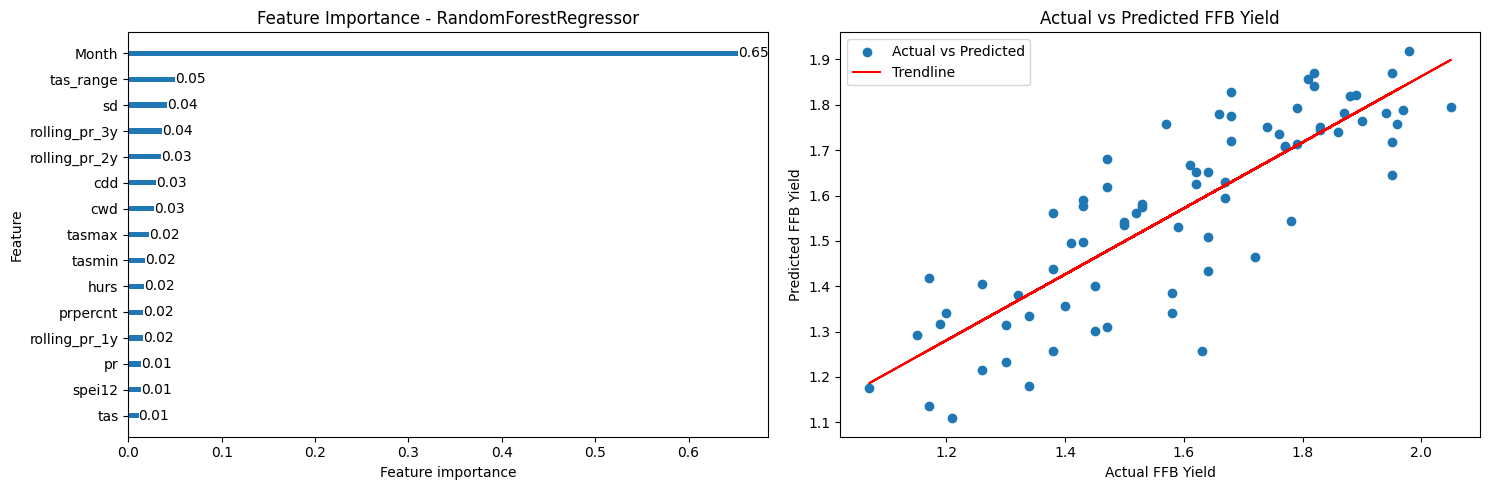

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
best_pipeline = tuned_model.best_estimator_
best_tuned_model = best_pipeline.named_steps['model']

importances = best_tuned_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot feature importance in the first subplot
ax[0].barh(range(X.shape[1]), importances[indices], align="center", height=0.2)
ax[0].set_yticks(range(X.shape[1]))
ax[0].set_yticklabels([features[i] for i in indices])
ax[0].set_xlabel("Feature importance")
ax[0].set_ylabel("Feature")
ax[0].set_title(f"Feature Importance - {best_model_name}")
ax[0].invert_yaxis()
for i in range(X.shape[1]):
    ax[0].text(importances[indices][i], i, f"{importances[indices][i]:.2f}", va='center')

# Plot actual vs predicted values in the second subplot
ax[1].scatter(y_test, best_model_y_pred, label='Actual vs Predicted')
ax[1].set_xlabel('Actual FFB Yield')
ax[1].set_ylabel('Predicted FFB Yield')
ax[1].set_title('Actual vs Predicted FFB Yield')
z = np.polyfit(y_test, best_model_y_pred, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test), color='red', label='Trendline')
ax[1].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()


In [ ]:
import joblib

joblib.dump(tuned_model, 'ffb_yield_model5.pkl')

['ffb_yield_model5.pkl']

In [ ]:
dummy_data = pd.DataFrame([[1, 100, 150, 80, 0.3, 25, 22, 30, 6.4, 25, 31, 8, 3600, 2400, 1200]],
                          columns=['Month', 'pr', 'prpercnt', 'hurs', 'spei12', 'tas', 'tasmin', 'tasmax','cdd', 'cwd', 'sd', 'tas_range', 'rolling_pr_3y', 'rolling_pr_2y', 'rolling_pr_1y'])



In [45]:
model_ffb = joblib.load('ffb_yield_model5.pkl')
v5 = model_ffb.predict(X)

print(f'model v5: {r2_score(y, v5)}')

model v5: 0.8379224653103237


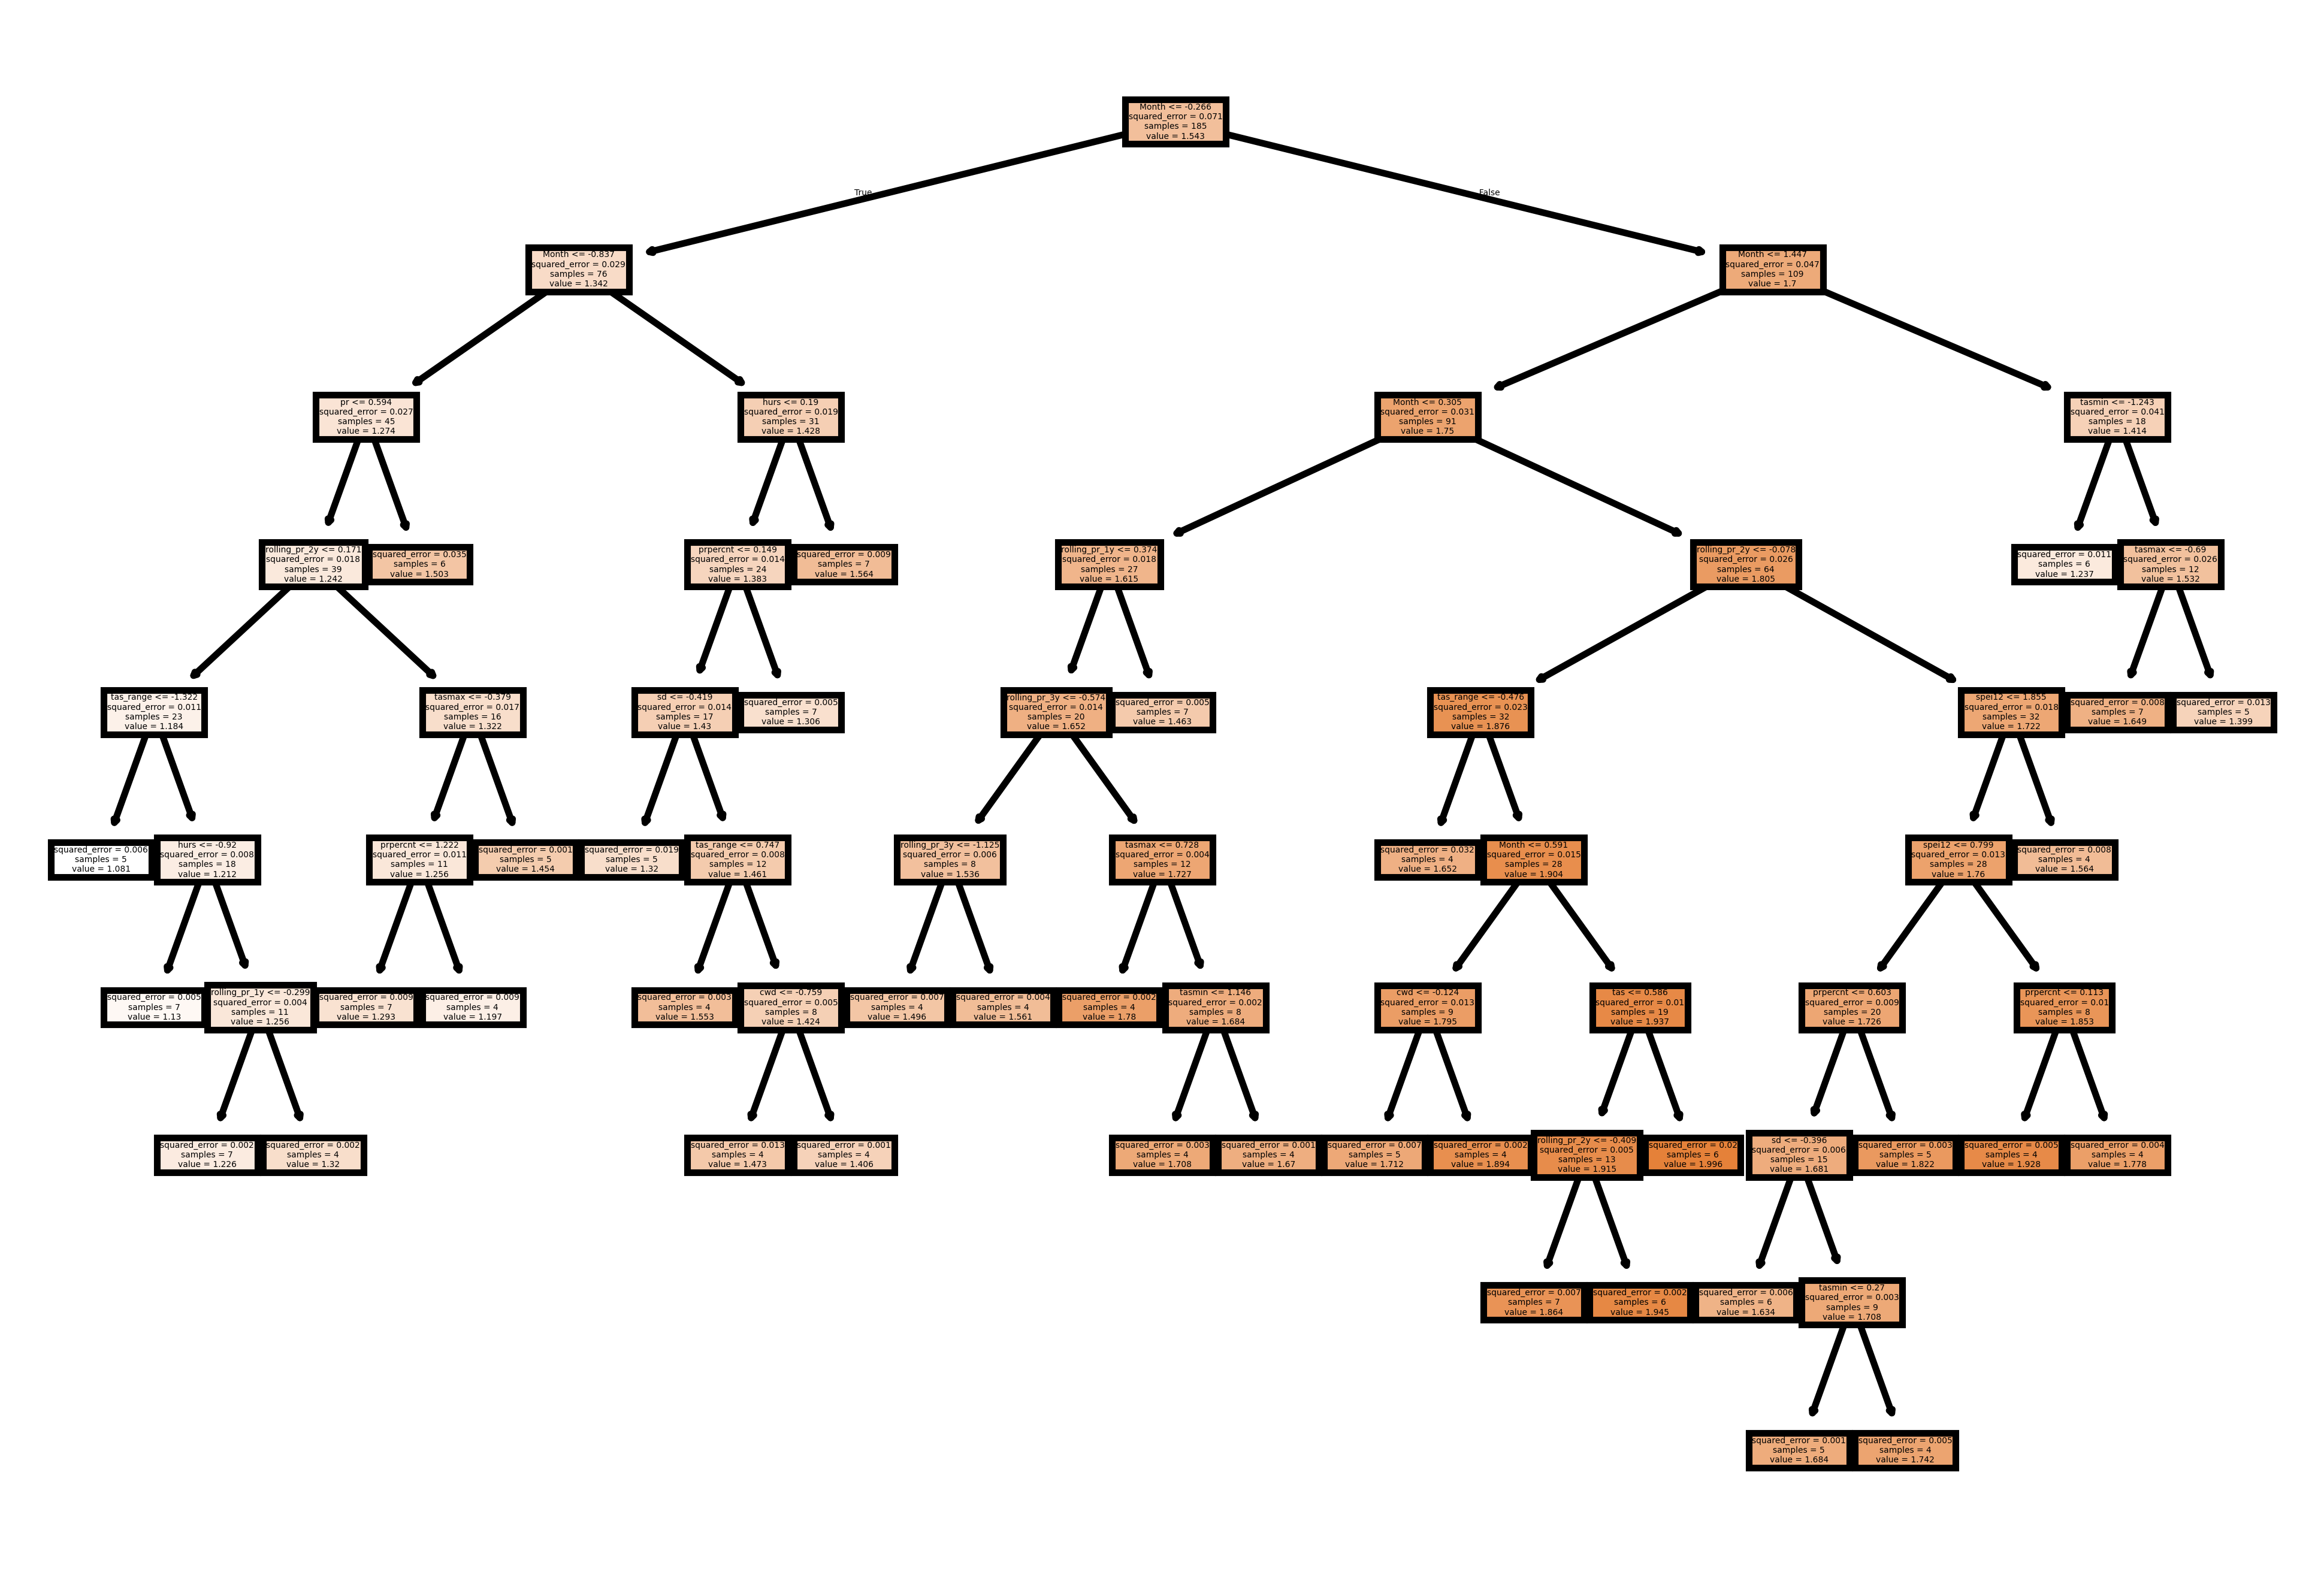

In [66]:
from sklearn import tree
import matplotlib.pyplot as plt
rf = model_ffb.best_estimator_.named_steps['model']
fn = X.columns
tn = 'FFB_Yield'

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn,
               filled=True);
fig.savefig('rf_individualtree.png')

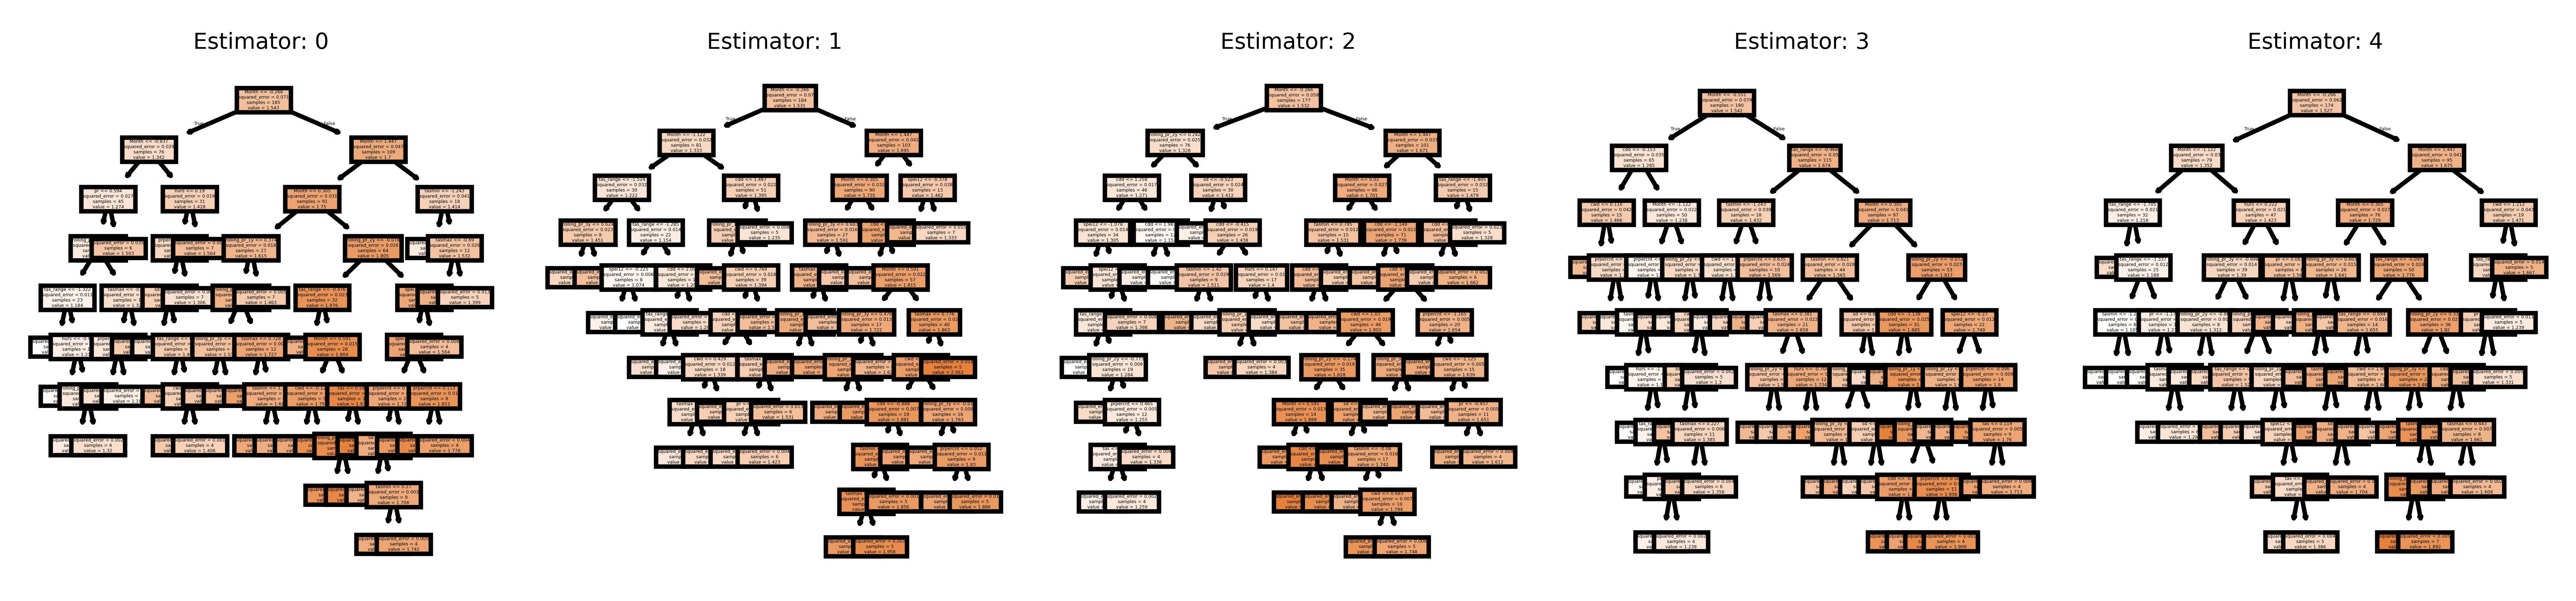

In [61]:
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf.estimators_[index],
                   feature_names = fn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 5)
fig.savefig('rf_5trees.png')

In [68]:
!pip install shap

# Modelling CPO

In [80]:
# split dataset into train and test
X = data_lag.drop(columns=['FFB_Yield', 'FFB_production', 'CPO_Yield', 'Year_Climate', 'Year_Harvested', 'Date'])
y_cpo = data_lag['CPO_Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y_cpo, test_size=0.2, random_state=42)

In [84]:
trained_models = {}
# define results table
results_cpo = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
results_cpo = pd.DataFrame(columns=['Model', 'MSE Mean', 'MSE Std', 'RMSE Mean', 'RMSE Std', 'MAE Mean', 'MAE Std', 'R2 Mean', 'R2 Std'])

# Define the models
cpo_model_LR = LinearRegression() # linear regression model
cpo_model_DTR = DecisionTreeRegressor(random_state=42) # Decision Tree Regressor model
cpo_model_RFR = RandomForestRegressor(random_state=42)  # Random Forest Regressor model
cpo_model_ABR = AdaBoostRegressor(random_state=42)
cpo_model_ETR = ExtraTreesRegressor()  # Extra Trees Regressor model

train_and_append_results(cpo_model_LR, results_cpo)
train_and_append_results(cpo_model_DTR, results_cpo)
train_and_append_results(cpo_model_RFR, results_cpo)
train_and_append_results(cpo_model_ABR, results_cpo)
train_and_append_results(cpo_model_ETR, results_cpo)

results_cpo.sort_values('R2 Mean', ascending=False)

Model  MSE Mean   MSE Std  RMSE Mean  RMSE Std  MAE Mean  \
2  RandomForestRegressor  0.001009  0.000185   0.031624  0.002927  0.025270   
4    ExtraTreesRegressor  0.001007  0.000129   0.031673  0.002014  0.025095   
3      AdaBoostRegressor  0.001115  0.000173   0.033293  0.002630  0.026495   
0       LinearRegression  0.001416  0.000121   0.037593  0.001644  0.029836   
1  DecisionTreeRegressor  0.001925  0.000300   0.043742  0.003417  0.035884   

    MAE Std   R2 Mean    R2 Std  
2  0.001984  0.636738  0.064122  
4  0.001090  0.633057  0.046657  
3  0.001952  0.599805  0.057285  
0  0.002021  0.490280  0.054874  
1  0.002432  0.309684  0.097157

In [86]:
best_model_name = results_cpo.loc[results_cpo['R2 Mean'].idxmax()]['Model']
best_pipeline = trained_models[best_model_name]['model']
best_model = best_pipeline.named_steps['model']
best_model_metrics = results_cpo[results_cpo['Model'] == best_model_name].iloc[0]  # Get metrics row
best_model_y_pred = trained_models[best_model_name]['y_pred']

print(f"Evaluation Metrics for the Best Model: {best_model_name}")
for metric in ['MSE Mean', 'MSE Std', 'RMSE Mean', 'RMSE Std', 'MAE Mean', 'MAE Std', 'R2 Mean', 'R2 Std']:
    print(f"{metric}: {best_model_metrics[metric]}")

Evaluation Metrics for the Best Model: RandomForestRegressor
MSE Mean: 0.001008653311864407
MSE Std: 0.00018511852291563507
RMSE Mean: 0.031624126755135575
RMSE Std: 0.002927100756640474
MAE Mean: 0.02527042937853106
MAE Std: 0.001984305842471342
R2 Mean: 0.6367381366060153
R2 Std: 0.06412233402763508


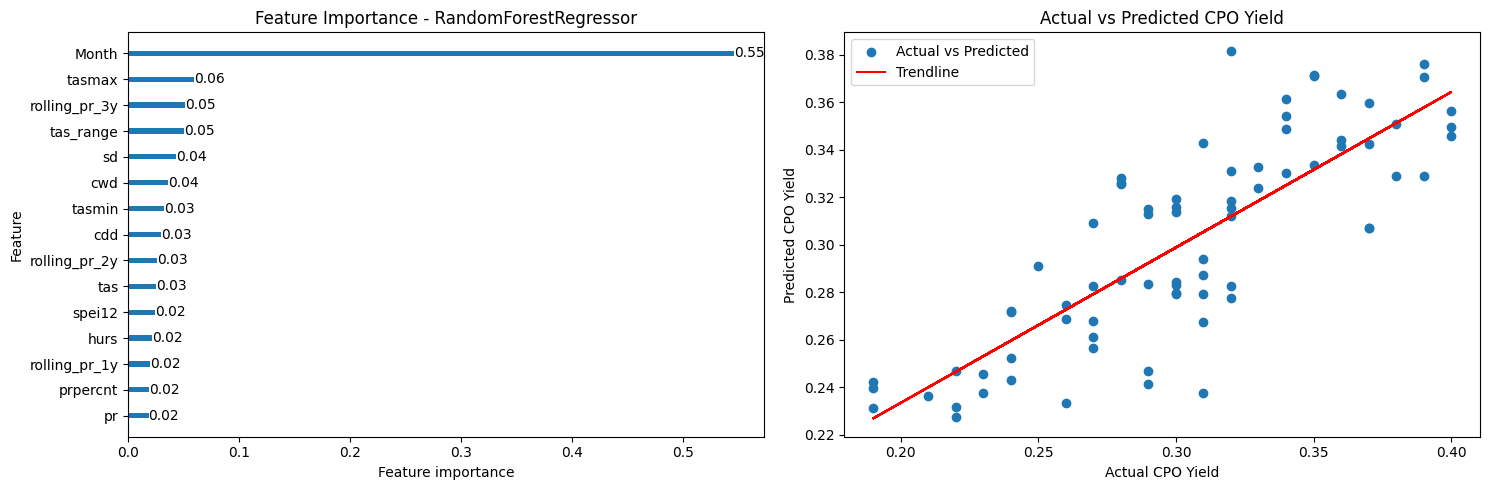

In [87]:
import numpy as np
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot feature importance in the first subplot
ax[0].barh(range(X.shape[1]), importances[indices], align="center", height=0.2)
ax[0].set_yticks(range(X.shape[1]))
ax[0].set_yticklabels([features[i] for i in indices])
ax[0].set_xlabel("Feature importance")
ax[0].set_ylabel("Feature")
ax[0].set_title(f"Feature Importance - {best_model_name}")
ax[0].invert_yaxis()
for i in range(X.shape[1]):
    ax[0].text(importances[indices][i], i, f"{importances[indices][i]:.2f}", va='center')

# Plot actual vs predicted values in the second subplot
ax[1].scatter(y_test, best_model_y_pred, label='Actual vs Predicted')
ax[1].set_xlabel('Actual CPO Yield')
ax[1].set_ylabel('Predicted CPO Yield')
ax[1].set_title('Actual vs Predicted CPO Yield')
z = np.polyfit(y_test, best_model_y_pred, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test), color='red', label='Trendline')
ax[1].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()

In [74]:
# get model parameters
for p in best_model.get_params():
    print(f'{p}: {best_model.get_params()[p]}')

bootstrap: False
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


In [88]:
param_grid = {
    'model__n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}


In [89]:
from sklearn.model_selection import RandomizedSearchCV


tuned_model = RandomizedSearchCV(estimator = best_pipeline, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1, scoring='r2', random_state=42)
tuned_model.fit(X_train, y_train)
print("Best Parameters:", tuned_model.best_params_)
print("Best Score:", tuned_model.best_score_)
for p in tuned_model.best_params_:
    print(f'{p}: {tuned_model.best_params_[p]}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'model__n_estimators': 400, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': None}
Best Score: 0.6217740361294499
model__n_estimators: 400
model__min_samples_split: 10
model__min_samples_leaf: 1
model__max_features: None
model__max_depth: None


In [90]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

# Predict using the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Calculate evaluation metrics for the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = root_mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

# Create a comparison table using Pandas DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'base_model': [best_model_metrics['MSE Mean'], best_model_metrics['RMSE Mean'], best_model_metrics['MAE Mean'], best_model_metrics['R2 Mean']],
    'tuned_model': [mse_tuned, rmse_tuned, mae_tuned, r2_tuned],
    'improvement %': [(best_model_metrics['MSE Mean'] - mse_tuned)/best_model_metrics['MAE Mean'] * 100,
                    (best_model_metrics['RMSE Mean'] - rmse_tuned)/best_model_metrics['RMSE Mean'] * 100,
                    (best_model_metrics['MAE Mean'] - mae_tuned)/best_model_metrics['MAE Mean'] * 100,
                    (r2_tuned - best_model_metrics['R2 Mean'])/best_model_metrics['R2 Mean'] * 100]

})
# Display the comparison table
print('Comparison of CPO model')
print(comparison_df)
print()

Comparison of CPO model
  Metric  base_model  tuned_model  improvement %
0    MSE    0.001009     0.000950       0.231395
1   RMSE    0.031624     0.030825       2.527042
2    MAE    0.025270     0.024992       1.102135
3     R2    0.636738     0.672093       5.552465



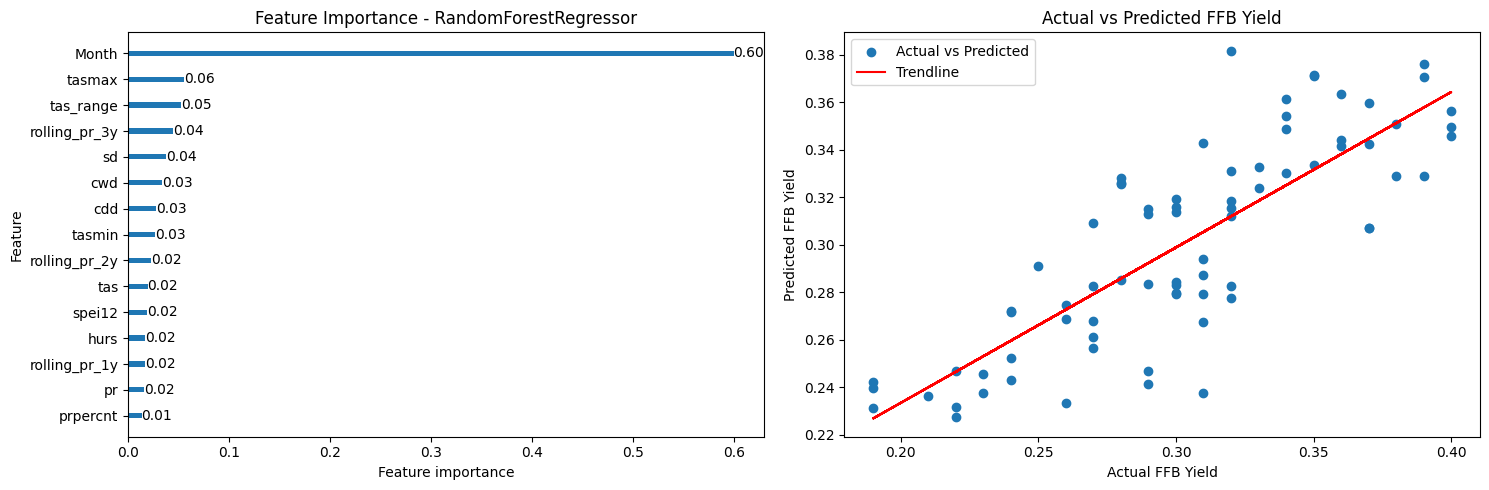

In [91]:
import numpy as np
import matplotlib.pyplot as plt
best_pipeline = tuned_model.best_estimator_
best_tuned_model = best_pipeline.named_steps['model']

importances = best_tuned_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot feature importance in the first subplot
ax[0].barh(range(X.shape[1]), importances[indices], align="center", height=0.2)
ax[0].set_yticks(range(X.shape[1]))
ax[0].set_yticklabels([features[i] for i in indices])
ax[0].set_xlabel("Feature importance")
ax[0].set_ylabel("Feature")
ax[0].set_title(f"Feature Importance - {best_model_name}")
ax[0].invert_yaxis()
for i in range(X.shape[1]):
    ax[0].text(importances[indices][i], i, f"{importances[indices][i]:.2f}", va='center')

# Plot actual vs predicted values in the second subplot
ax[1].scatter(y_test, best_model_y_pred, label='Actual vs Predicted')
ax[1].set_xlabel('Actual FFB Yield')
ax[1].set_ylabel('Predicted FFB Yield')
ax[1].set_title('Actual vs Predicted FFB Yield')
z = np.polyfit(y_test, best_model_y_pred, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test), color='red', label='Trendline')
ax[1].legend()

# Adjust layout and show the combined figure
plt.tight_layout()
plt.show()


In [78]:
import joblib

joblib.dump(tuned_model, 'cpo_yield_model5.pkl')


['cpo_yield_model5.pkl']

In [92]:
model5 = joblib.load('cpo_yield_model5.pkl')
v5 = model5.predict(X)

print(f'model v5: {r2_score(y, v5)}')

model v5: -22.63849427789775
